In [2]:
from tqdm import tqdm
from os import listdir
from random import *
seed(0)


import pandas as pd

from pylab import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cuda:0"

## Data trepanation

In [3]:
dataset = 'barents'
folder_train, folder_val, folder_test = dataset + '/train/maps/', dataset + '/valid/maps/', dataset + '/test/maps/'
train_files, val_files, test_files = sorted([file for file in listdir(folder_train)])[1346:],\
                                     sorted([file for file in listdir(folder_val)]),\
                                     sorted([file for file in listdir(folder_test)]) # + 1200

sample = torch.load(folder_train + train_files[1])
grid = torch.load(dataset + "/train/grid.pt")
coverage = pd.read_csv(dataset + "/train/coverage.csv")

len(train_files), len(val_files), len(test_files)

(1812, 366, 365)

In [4]:
keys = sample.keys()

In [5]:
def nan_check(tensor: torch.Tensor) -> bool:
    return True in tensor.isnan()

for key in keys:
    print(nan_check(sample[key]), key, sample[key].shape)

True cryosat.sic torch.Size([360, 500])
True cryosat.sit torch.Size([360, 500])
True jaxa.sic_asc torch.Size([360, 500])
True jaxa.sic_desc torch.Size([360, 500])
True jaxa.sic torch.Size([360, 500])
False gfs.f0d.temperature torch.Size([360, 500])
False gfs.f0d.pressure torch.Size([360, 500])
False gfs.f0d.wind_u torch.Size([360, 500])
False gfs.f0d.wind_v torch.Size([360, 500])
False gfs.f0d.wind torch.Size([360, 500])
False gfs.f1d.temperature torch.Size([360, 500])
False gfs.f1d.pressure torch.Size([360, 500])
False gfs.f1d.wind_u torch.Size([360, 500])
False gfs.f1d.wind_v torch.Size([360, 500])
False gfs.f1d.wind torch.Size([360, 500])
False gfs.f2d.temperature torch.Size([360, 500])
False gfs.f2d.pressure torch.Size([360, 500])
False gfs.f2d.wind_u torch.Size([360, 500])
False gfs.f2d.wind_v torch.Size([360, 500])
False gfs.f2d.wind torch.Size([360, 500])
False gfs.f3d.temperature torch.Size([360, 500])
False gfs.f3d.pressure torch.Size([360, 500])
False gfs.f3d.wind_u torch.Siz

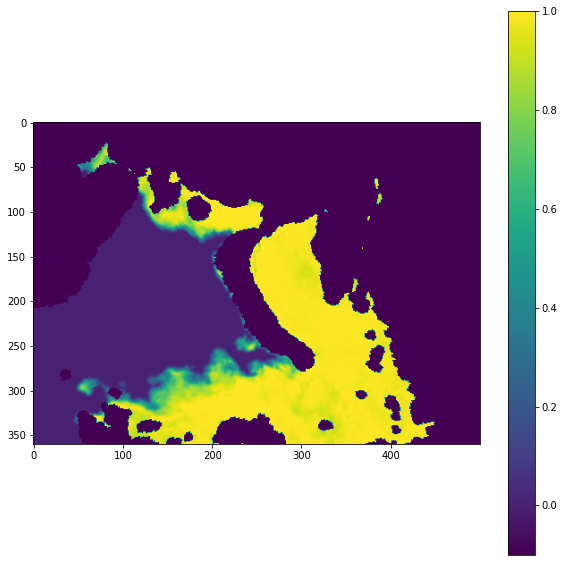

In [6]:
def preprocess_image(tensor: torch.Tensor) -> torch.Tensor:
    return (torch.nan_to_num(tensor, nan=-10.0))/100 # + grid['land']*10

plt.figure(figsize=(10,10))
axs = imshow(preprocess_image(sample["jaxa.sic"]).reshape(360, 500).detach().cpu().numpy())
plt.colorbar()

In [7]:
images_train = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(train_files)))]
images_val = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(val_files)))]
images_test = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(test_files)))]

100%|██████████| 365/365 [00:05<00:00, 67.01it/s]


In [8]:
images_tensor_train, images_tensor_val, images_tensor_test = torch.stack(images_train).to(device),\
                                                             torch.stack(images_val).to(device),\
                                                             torch.stack(images_test).to(device)
images_tensor_train.shape

torch.Size([1812, 360, 500])

## Model trepanation

#### Check whether NaNs of the SIC part in the same positions or not

In [8]:
images_train_raw = [torch.load(folder_train + train_files[i])["jaxa.sic"]\
                            for i in tqdm(range(0, len(train_files)))]

images_val_raw = [torch.load(folder_val + val_files[i])["jaxa.sic"]\
                            for i in tqdm(range(0, len(val_files)))]

def handler(data: dict):
    try:
#        print(data["jaxa.sic"])
        return data["jaxa.sic"]
    except:
#        print(data["jaxa.sic_asc"])
        return data["jaxa.sic_asc"]
    
images_test_raw = [handler(torch.load(folder_test + test_files[i]))\
                            for i in tqdm(range(0, len(test_files)))]

100%|██████████| 365/365 [00:06<00:00, 52.48it/s]


In [9]:
ref_mask = torch.isnan(images_train_raw[0])

diffs = []

for split in [images_train_raw, images_val_raw, images_test_raw]:
    data_2_check = [torch.logical_xor(torch.isnan(image), ref_mask) for image in split]
    diffs.append(data_2_check)

In [10]:
# ultimate mask correcions

diffs[2][181] = ~diffs[2][181]

diffs[0][323] = diffs[0][322]
diffs[0][987] = diffs[0][986]

In [11]:
from copy import deepcopy

ref_mask = torch.isnan(images_train_raw[0])
ultimate_mask = deepcopy(ref_mask)

for split in diffs:
    print('---')
    for i, image in enumerate(split[:]):
        if (torch.sum(image.float()) > 2*981.):
            print(i, torch.sum(image.float()))
        ultimate_mask = torch.logical_or(ultimate_mask, image)

---
457 tensor(2107.)
---
76 tensor(2075.)
---
60 tensor(2162.)
181 tensor(101124.)


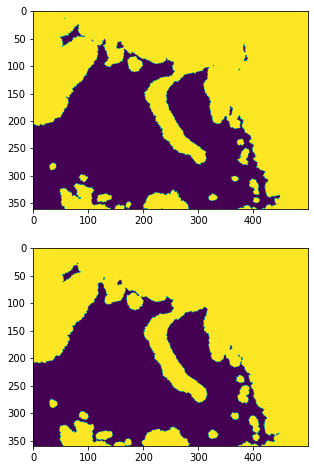

In [74]:
ref_mask = torch.isnan(images_train_raw[0])

fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].imshow(ref_mask)
ax[1].imshow(ultimate_mask)
# plt.colorbar()

In [12]:
torch.save(ultimate_mask, 'mask_barents.pt')

In [9]:
ultimate_mask = torch.load('mask_barents.pt')

#### Actual experiments

In [17]:
def average(data: list) -> float:
    return sum(data)/len(data)

def load_data(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        in_batch.append(images_tensor[start_point:start_point+d_in])
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out])
    return torch.stack(in_batch), torch.stack(out_batch)

def train(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion_mse = nn.MSELoss()
#weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    for epoch in range(epochs):
        model.train()
        
        images_in, images_out = load_data(batch_size, images_tensor_train, d_in, d_out)
        optimizer.zero_grad()
        model_out = model(images_in) + images_in[:,-1, None, :, :].repeat(1, 3, 1, 1)
        
        adapted_mask = ~ultimate_mask[None, None, :].repeat(batch_size,3,1,1)
        
        loss = criterion(model_out[adapted_mask], images_out[adapted_mask])
        loss.backward() # retain_graph=True
        
#        print(model_out.shape, images_out.shape)
        
        optimizer.step()
        
        if epoch % eval_step == 0:
            with torch.no_grad():
                model.eval()

                mae_total, rmse_total, mape_total = [], [], []

                total_test_len = len(images_tensor_test)
                start_point, steps = 0, int(total_test_len/(d_in + d_out))

                for i in range(steps):
                    images_in, images_out = images_tensor_test[start_point:start_point+d_in],\
                                            images_tensor_test[start_point+d_in:start_point+d_in+d_out]

                    start_point += d_in + d_out

                   # model_out = images_in[-1][None, :, :].repeat(3, 1, 1)[None, :, : , :]
                    model_out = model(images_in[None, :, :, :]) + images_in[-1].repeat(3, 1, 1)[None, :, :, :] 

                    #                print(model_out.shape)
                
                    adapted_mask = ~ultimate_mask[None, None, :].repeat(1,3,1,1)

                    loss_mse = criterion_mse(model_out[adapted_mask], images_out[None, :, :, :][adapted_mask])
                    loss_mae = criterion(model_out[adapted_mask], images_out[None, :, :, :][adapted_mask])

                    mae_total.append(loss_mae.detach().cpu().numpy())
                    rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                
            
                wandb.log(
                    {
                     "test/test_MAE": average(mae_total), 
                     "test/test_RMSE": average(rmse_total)
                    }
                )
            
            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

In [ ]:
architecture = "UNet_7:3_per"
i = 0
wandb.init(project="initial_tests_RE", entity="sea-ice-prediction", group=architecture)
wandb.run.name = architecture + "_" + str(i)  # "gs_3_ffd_3_128_test_MAEloss_lr_10^{-4}_10000"
wandb.run.save()

test/test_MAE,0.02289
test/test_RMSE,0.06981
_runtime,23950
_timestamp,1693482129
_step,18499


test/test_MAE,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/test_RMSE,█▇▇▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.15.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/sea-ice-prediction/initial_tests_RE/3scdim9o/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/sea-ice-prediction/initial_tests_RE/3scdim9o/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/sea-ice-prediction/initial_tests_RE/3scdim9o/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/sea-ice-prediction/initial_tests_RE/3scdim9o/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-inter

In [12]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [13]:
from models.unet.unet.unet_model import UNet

epochs = 300
d_in, d_out = 7, 3
batch_size = 8
lr = 1e-3
eval_step = 1
criterion = nn.L1Loss()
model = UNet(d_in, d_out).to(device)

train(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step)

Epoch  0 , test MAE -  0.06320001681645711
Epoch  1 , test MAE -  0.05579311317867703
Epoch  2 , test MAE -  0.05288971463839213
Epoch  3 , test MAE -  0.052060484886169434
Epoch  4 , test MAE -  0.05244444476233588
Epoch  5 , test MAE -  0.05210396647453308
Epoch  6 , test MAE -  0.05140660868750678
Epoch  7 , test MAE -  0.049158831437428795
Epoch  8 , test MAE -  0.04879873659875658
Epoch  9 , test MAE -  0.04929624332322015
Epoch  10 , test MAE -  0.04787514607111613
Epoch  11 , test MAE -  0.04458919167518616
Epoch  12 , test MAE -  0.04513208402527703
Epoch  13 , test MAE -  0.046312557326422796
Epoch  14 , test MAE -  0.047060387002097234
Epoch  15 , test MAE -  0.046905206309424505
Epoch  16 , test MAE -  0.048268424140082464
Epoch  17 , test MAE -  0.04833035667737325
Epoch  18 , test MAE -  0.04896206988228692
Epoch  19 , test MAE -  0.05344419678052267
Epoch  20 , test MAE -  0.060582134458753795
Epoch  21 , test MAE -  0.05968769391377767
Epoch  22 , test MAE -  0.051635732

Epoch  183 , test MAE -  0.028126600715849135
Epoch  184 , test MAE -  0.028553863366444904
Epoch  185 , test MAE -  0.02893507480621338
Epoch  186 , test MAE -  0.028893096579445735
Epoch  187 , test MAE -  0.028101513783137005
Epoch  188 , test MAE -  0.027791791492038302
Epoch  189 , test MAE -  0.027698285049862333
Epoch  190 , test MAE -  0.027544766664505005
Epoch  191 , test MAE -  0.027897503640916612
Epoch  192 , test MAE -  0.028138322962654963
Epoch  193 , test MAE -  0.028315626912646823
Epoch  194 , test MAE -  0.028228312730789185
Epoch  195 , test MAE -  0.02795091602537367
Epoch  196 , test MAE -  0.027635493212276034
Epoch  197 , test MAE -  0.02769670055972205
Epoch  198 , test MAE -  0.02782395813200209
Epoch  199 , test MAE -  0.028034749958250258
Epoch  200 , test MAE -  0.028435018327501085
Epoch  201 , test MAE -  0.028717537720998127
Epoch  202 , test MAE -  0.028793685966067843
Epoch  203 , test MAE -  0.02887841396861606
Epoch  204 , test MAE -  0.028377268049

In [14]:
epochs = 3200
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-4, eval_step)

Epoch  0 , test MAE -  0.028401570187674627
Epoch  1 , test MAE -  0.028330365816752117
Epoch  2 , test MAE -  0.028127693467670016
Epoch  3 , test MAE -  0.027910480896631878
Epoch  4 , test MAE -  0.027811169624328613
Epoch  5 , test MAE -  0.02783546845118205
Epoch  6 , test MAE -  0.028017554018232558
Epoch  7 , test MAE -  0.02811923623085022
Epoch  8 , test MAE -  0.02830099066098531
Epoch  9 , test MAE -  0.028516418404049344
Epoch  10 , test MAE -  0.02861917018890381
Epoch  11 , test MAE -  0.028462751044167414
Epoch  12 , test MAE -  0.02822360396385193
Epoch  13 , test MAE -  0.028005537059572008
Epoch  14 , test MAE -  0.02787862221399943
Epoch  15 , test MAE -  0.027699212233225506
Epoch  16 , test MAE -  0.027536716726091173
Epoch  17 , test MAE -  0.027346490157975092
Epoch  18 , test MAE -  0.02721145252386729
Epoch  19 , test MAE -  0.027179289195272658
Epoch  20 , test MAE -  0.027268110050095454
Epoch  21 , test MAE -  0.027321736017862957
Epoch  22 , test MAE -  0.0

Epoch  182 , test MAE -  0.027769737773471408
Epoch  183 , test MAE -  0.02770220736662547
Epoch  184 , test MAE -  0.027682415313190885
Epoch  185 , test MAE -  0.02773239380783505
Epoch  186 , test MAE -  0.02786889672279358
Epoch  187 , test MAE -  0.02784276670879788
Epoch  188 , test MAE -  0.027847935756047566
Epoch  189 , test MAE -  0.027834097544352215
Epoch  190 , test MAE -  0.0278199745549096
Epoch  191 , test MAE -  0.027862356768714056
Epoch  192 , test MAE -  0.027848614586724177
Epoch  193 , test MAE -  0.02780282497406006
Epoch  194 , test MAE -  0.027751513653331332
Epoch  195 , test MAE -  0.027703622976938885
Epoch  196 , test MAE -  0.02765293253792657
Epoch  197 , test MAE -  0.027570406595865887
Epoch  198 , test MAE -  0.027442718545595806
Epoch  199 , test MAE -  0.027406137850549486
Epoch  200 , test MAE -  0.027358955807156034
Epoch  201 , test MAE -  0.027294283111890156
Epoch  202 , test MAE -  0.02723456256919437
Epoch  203 , test MAE -  0.0271643996238708

Epoch  362 , test MAE -  0.027011268668704562
Epoch  363 , test MAE -  0.027047226826349895
Epoch  364 , test MAE -  0.027017672856648762
Epoch  365 , test MAE -  0.02703928119606442
Epoch  366 , test MAE -  0.026902364359961614
Epoch  367 , test MAE -  0.026801786488956876
Epoch  368 , test MAE -  0.026802452074156866
Epoch  369 , test MAE -  0.026783059040705364
Epoch  370 , test MAE -  0.0267459683948093
Epoch  371 , test MAE -  0.02681403524345822
Epoch  372 , test MAE -  0.026848793029785156
Epoch  373 , test MAE -  0.0268649955590566
Epoch  374 , test MAE -  0.026863818367322285
Epoch  375 , test MAE -  0.026818583408991497
Epoch  376 , test MAE -  0.026799672179751925
Epoch  377 , test MAE -  0.026812748776541814
Epoch  378 , test MAE -  0.026840355661180284
Epoch  379 , test MAE -  0.02697585854265425
Epoch  380 , test MAE -  0.027144801285531785
Epoch  381 , test MAE -  0.0272067387898763
Epoch  382 , test MAE -  0.0271442002720303
Epoch  383 , test MAE -  0.027055596311887104

Epoch  542 , test MAE -  0.027276501059532166
Epoch  543 , test MAE -  0.027157397733794317
Epoch  544 , test MAE -  0.027086822523011103
Epoch  545 , test MAE -  0.02702642811669244
Epoch  546 , test MAE -  0.02688002089659373
Epoch  547 , test MAE -  0.026828423142433167
Epoch  548 , test MAE -  0.02678048113981883
Epoch  549 , test MAE -  0.026855299870173138
Epoch  550 , test MAE -  0.02691057821114858
Epoch  551 , test MAE -  0.026864629652765062
Epoch  552 , test MAE -  0.026760892735587224
Epoch  553 , test MAE -  0.026731620232264202
Epoch  554 , test MAE -  0.02672210004594591
Epoch  555 , test MAE -  0.026707015103764005
Epoch  556 , test MAE -  0.026719224121835496
Epoch  557 , test MAE -  0.02678313520219591
Epoch  558 , test MAE -  0.026863290203942194
Epoch  559 , test MAE -  0.026873287227418687
Epoch  560 , test MAE -  0.026814492212401494
Epoch  561 , test MAE -  0.026849518219629925
Epoch  562 , test MAE -  0.02688771817419264
Epoch  563 , test MAE -  0.02688227262761

Epoch  722 , test MAE -  0.026652508311801486
Epoch  723 , test MAE -  0.026709551612536114
Epoch  724 , test MAE -  0.02683920164903005
Epoch  725 , test MAE -  0.026836981376012165
Epoch  726 , test MAE -  0.02687251567840576
Epoch  727 , test MAE -  0.02678434881899092
Epoch  728 , test MAE -  0.0267029388083352
Epoch  729 , test MAE -  0.027262260516484577
Epoch  730 , test MAE -  0.027234706613752577
Epoch  731 , test MAE -  0.027205074826876324
Epoch  732 , test MAE -  0.02712470789750417
Epoch  733 , test MAE -  0.027297241820229426
Epoch  734 , test MAE -  0.027362916204664443
Epoch  735 , test MAE -  0.0274227692021264
Epoch  736 , test MAE -  0.02744804984993405
Epoch  737 , test MAE -  0.027418855163786147
Epoch  738 , test MAE -  0.027400160829226177
Epoch  739 , test MAE -  0.027371457881397672
Epoch  740 , test MAE -  0.02731564806567298
Epoch  741 , test MAE -  0.027267557051446702
Epoch  742 , test MAE -  0.027415273918045893
Epoch  743 , test MAE -  0.02762178745534685

Epoch  902 , test MAE -  0.026307369271914165
Epoch  903 , test MAE -  0.026330045527882047
Epoch  904 , test MAE -  0.026350529657469854
Epoch  905 , test MAE -  0.026336304015583463
Epoch  906 , test MAE -  0.026265717215008207
Epoch  907 , test MAE -  0.026238608691427443
Epoch  908 , test MAE -  0.026267939143710665
Epoch  909 , test MAE -  0.026346534490585327
Epoch  910 , test MAE -  0.026449968417485554
Epoch  911 , test MAE -  0.0265529602766037
Epoch  912 , test MAE -  0.02651568916108873
Epoch  913 , test MAE -  0.026448120673497517
Epoch  914 , test MAE -  0.026328267322646245
Epoch  915 , test MAE -  0.026202915443314448
Epoch  916 , test MAE -  0.026143319076961942
Epoch  917 , test MAE -  0.026115232043796115
Epoch  918 , test MAE -  0.02616351842880249
Epoch  919 , test MAE -  0.0262000345521503
Epoch  920 , test MAE -  0.026224500603146024
Epoch  921 , test MAE -  0.026173777050442167
Epoch  922 , test MAE -  0.026116559902826946
Epoch  923 , test MAE -  0.0261582848098

Epoch  1080 , test MAE -  0.02593741814295451
Epoch  1081 , test MAE -  0.025927876432736714
Epoch  1082 , test MAE -  0.0259430640273624
Epoch  1083 , test MAE -  0.025972285204463534
Epoch  1084 , test MAE -  0.026024834977255926
Epoch  1085 , test MAE -  0.026026094953219097
Epoch  1086 , test MAE -  0.02606001330746545
Epoch  1087 , test MAE -  0.026051195131407842
Epoch  1088 , test MAE -  0.026037345329920452
Epoch  1089 , test MAE -  0.026060175564554002
Epoch  1090 , test MAE -  0.026167498694525823
Epoch  1091 , test MAE -  0.026221025321218703
Epoch  1092 , test MAE -  0.026287236147456698
Epoch  1093 , test MAE -  0.026145226425594754
Epoch  1094 , test MAE -  0.026101966698964436
Epoch  1095 , test MAE -  0.02604597310225169
Epoch  1096 , test MAE -  0.026020636161168415
Epoch  1097 , test MAE -  0.025906920433044434
Epoch  1098 , test MAE -  0.025816152493158977
Epoch  1099 , test MAE -  0.0257938371764289
Epoch  1100 , test MAE -  0.025817399223645527
Epoch  1101 , test M

Epoch  1256 , test MAE -  0.02549507220586141
Epoch  1257 , test MAE -  0.02557287447982364
Epoch  1258 , test MAE -  0.025521342953046162
Epoch  1259 , test MAE -  0.02544466157754262
Epoch  1260 , test MAE -  0.025485133131345112
Epoch  1261 , test MAE -  0.025479132930437725
Epoch  1262 , test MAE -  0.02548877067036099
Epoch  1263 , test MAE -  0.025487798783514235
Epoch  1264 , test MAE -  0.025527551770210266
Epoch  1265 , test MAE -  0.02550544838110606
Epoch  1266 , test MAE -  0.025470700528886583
Epoch  1267 , test MAE -  0.025504925184779696
Epoch  1268 , test MAE -  0.025517364343007404
Epoch  1269 , test MAE -  0.02554287513097127
Epoch  1270 , test MAE -  0.025492034024662442
Epoch  1271 , test MAE -  0.025465127494600084
Epoch  1272 , test MAE -  0.025431338283750746
Epoch  1273 , test MAE -  0.025579267077975802
Epoch  1274 , test MAE -  0.025546173254648846
Epoch  1275 , test MAE -  0.02548412813080682
Epoch  1276 , test MAE -  0.02546684940656026
Epoch  1277 , test MA

Epoch  1432 , test MAE -  0.02557804352707333
Epoch  1433 , test MAE -  0.025698562463124592
Epoch  1434 , test MAE -  0.025810986757278442
Epoch  1435 , test MAE -  0.025860413908958435
Epoch  1436 , test MAE -  0.025802195072174072
Epoch  1437 , test MAE -  0.025805355774031744
Epoch  1438 , test MAE -  0.025718741946750216
Epoch  1439 , test MAE -  0.025587914718521967
Epoch  1440 , test MAE -  0.025568753480911255
Epoch  1441 , test MAE -  0.02549228072166443
Epoch  1442 , test MAE -  0.025460354155964322
Epoch  1443 , test MAE -  0.02542352345254686
Epoch  1444 , test MAE -  0.025399636891153123
Epoch  1445 , test MAE -  0.025338560342788696
Epoch  1446 , test MAE -  0.02523617446422577
Epoch  1447 , test MAE -  0.025128339727719624
Epoch  1448 , test MAE -  0.025082670980029635
Epoch  1449 , test MAE -  0.02511123816172282
Epoch  1450 , test MAE -  0.025223579671647813
Epoch  1451 , test MAE -  0.02535810901059045
Epoch  1452 , test MAE -  0.025557974974314373
Epoch  1453 , test 

Epoch  1608 , test MAE -  0.025230593151516385
Epoch  1609 , test MAE -  0.02518778211540646
Epoch  1610 , test MAE -  0.025091303719414607
Epoch  1611 , test MAE -  0.025031107995245192
Epoch  1612 , test MAE -  0.025022296441925898
Epoch  1613 , test MAE -  0.024955039223035175
Epoch  1614 , test MAE -  0.02486382093694475
Epoch  1615 , test MAE -  0.024832914272944134
Epoch  1616 , test MAE -  0.024824852744738262
Epoch  1617 , test MAE -  0.0248091717561086
Epoch  1618 , test MAE -  0.024844621618588764
Epoch  1619 , test MAE -  0.02483051187462277
Epoch  1620 , test MAE -  0.024857413437631395
Epoch  1621 , test MAE -  0.024846161405245464
Epoch  1622 , test MAE -  0.02483885321352217
Epoch  1623 , test MAE -  0.024800697962443035
Epoch  1624 , test MAE -  0.024813749723964267
Epoch  1625 , test MAE -  0.024947504202524822
Epoch  1626 , test MAE -  0.025150163306130305
Epoch  1627 , test MAE -  0.02500087519486745
Epoch  1628 , test MAE -  0.025069970223638747
Epoch  1629 , test M

Epoch  1784 , test MAE -  0.02557957172393799
Epoch  1785 , test MAE -  0.0255749159389072
Epoch  1786 , test MAE -  0.02544776267475552
Epoch  1787 , test MAE -  0.02546606957912445
Epoch  1788 , test MAE -  0.02559508052137163
Epoch  1789 , test MAE -  0.025710895657539368
Epoch  1790 , test MAE -  0.025860471857918635
Epoch  1791 , test MAE -  0.025870692398813035
Epoch  1792 , test MAE -  0.02593001061015659
Epoch  1793 , test MAE -  0.02591052816973792
Epoch  1794 , test MAE -  0.025890707969665527
Epoch  1795 , test MAE -  0.025743055674764845
Epoch  1796 , test MAE -  0.025694525904125638
Epoch  1797 , test MAE -  0.02564382553100586
Epoch  1798 , test MAE -  0.025571551587846544
Epoch  1799 , test MAE -  0.02541502316792806
Epoch  1800 , test MAE -  0.025261743201149836
Epoch  1801 , test MAE -  0.02512374023596446
Epoch  1802 , test MAE -  0.025140432847870722
Epoch  1803 , test MAE -  0.025141020615895588
Epoch  1804 , test MAE -  0.025139502353138395
Epoch  1805 , test MAE -

Epoch  1960 , test MAE -  0.024865456753306918
Epoch  1961 , test MAE -  0.02482161091433631
Epoch  1962 , test MAE -  0.02475498119990031
Epoch  1963 , test MAE -  0.024724652369817097
Epoch  1964 , test MAE -  0.024730192290412054
Epoch  1965 , test MAE -  0.024732357925838895
Epoch  1966 , test MAE -  0.024740091628498502
Epoch  1967 , test MAE -  0.024694085121154785
Epoch  1968 , test MAE -  0.0246479246351454
Epoch  1969 , test MAE -  0.024550583627488878
Epoch  1970 , test MAE -  0.024504626790682476
Epoch  1971 , test MAE -  0.024566908677419026
Epoch  1972 , test MAE -  0.024572129050890606
Epoch  1973 , test MAE -  0.0246052708890703
Epoch  1974 , test MAE -  0.02457479139169057
Epoch  1975 , test MAE -  0.024552543958028156
Epoch  1976 , test MAE -  0.02455021606551276
Epoch  1977 , test MAE -  0.024542717470063105
Epoch  1978 , test MAE -  0.024504409896002874
Epoch  1979 , test MAE -  0.024452143245273165
Epoch  1980 , test MAE -  0.024468865659501817
Epoch  1981 , test MA

Epoch  2136 , test MAE -  0.02468355827861362
Epoch  2137 , test MAE -  0.0244361807902654
Epoch  2138 , test MAE -  0.02456030746301015
Epoch  2139 , test MAE -  0.024595545397864446
Epoch  2140 , test MAE -  0.02458778851562076
Epoch  2141 , test MAE -  0.02456679277949863
Epoch  2142 , test MAE -  0.024522405531671312
Epoch  2143 , test MAE -  0.02449012299378713
Epoch  2144 , test MAE -  0.02452026969856686
Epoch  2145 , test MAE -  0.024547959367434185
Epoch  2146 , test MAE -  0.02451833751466539
Epoch  2147 , test MAE -  0.024461181627379522
Epoch  2148 , test MAE -  0.024472281336784363
Epoch  2149 , test MAE -  0.024503446287579007
Epoch  2150 , test MAE -  0.02461119492848714
Epoch  2151 , test MAE -  0.024583192335234746
Epoch  2152 , test MAE -  0.024510073992941115
Epoch  2153 , test MAE -  0.024450313713815477
Epoch  2154 , test MAE -  0.024437149365743
Epoch  2155 , test MAE -  0.024428258339564007
Epoch  2156 , test MAE -  0.02438685132397546
Epoch  2157 , test MAE -  0

Epoch  2312 , test MAE -  0.024531900882720947
Epoch  2313 , test MAE -  0.024481334620051913
Epoch  2314 , test MAE -  0.02450684706370036
Epoch  2315 , test MAE -  0.02446351945400238
Epoch  2316 , test MAE -  0.024471119046211243
Epoch  2317 , test MAE -  0.024491897887653775
Epoch  2318 , test MAE -  0.02464997933970557
Epoch  2319 , test MAE -  0.02458681994014316
Epoch  2320 , test MAE -  0.024615352352460224
Epoch  2321 , test MAE -  0.024661845631069608
Epoch  2322 , test MAE -  0.02467675507068634
Epoch  2323 , test MAE -  0.024716302752494812
Epoch  2324 , test MAE -  0.024816031257311504
Epoch  2325 , test MAE -  0.024911810954411823
Epoch  2326 , test MAE -  0.02490824129846361
Epoch  2327 , test MAE -  0.02490369313293033
Epoch  2328 , test MAE -  0.02480088174343109
Epoch  2329 , test MAE -  0.0247256424691942
Epoch  2330 , test MAE -  0.024653257595168218
Epoch  2331 , test MAE -  0.024766087532043457
Epoch  2332 , test MAE -  0.024808542595969305
Epoch  2333 , test MAE 

Epoch  2488 , test MAE -  0.02473009791639116
Epoch  2489 , test MAE -  0.02472511265012953
Epoch  2490 , test MAE -  0.02462686598300934
Epoch  2491 , test MAE -  0.024535583125220403
Epoch  2492 , test MAE -  0.02447535428735945
Epoch  2493 , test MAE -  0.02446293168597751
Epoch  2494 , test MAE -  0.024484205577108595
Epoch  2495 , test MAE -  0.024487892786661785
Epoch  2496 , test MAE -  0.024481917421023052
Epoch  2497 , test MAE -  0.024520590901374817
Epoch  2498 , test MAE -  0.02460609707567427
Epoch  2499 , test MAE -  0.024776493509610493
Epoch  2500 , test MAE -  0.024655721253818937
Epoch  2501 , test MAE -  0.02450903256734212
Epoch  2502 , test MAE -  0.024471652176645067
Epoch  2503 , test MAE -  0.02447767224576738
Epoch  2504 , test MAE -  0.0244533552063836
Epoch  2505 , test MAE -  0.024533925784958735
Epoch  2506 , test MAE -  0.024591096573405795
Epoch  2507 , test MAE -  0.024701901608043246
Epoch  2508 , test MAE -  0.02483305831750234
Epoch  2509 , test MAE -

Epoch  2664 , test MAE -  0.024253414736853704
Epoch  2665 , test MAE -  0.02430264155069987
Epoch  2666 , test MAE -  0.02434003518687354
Epoch  2667 , test MAE -  0.024390624629126653
Epoch  2668 , test MAE -  0.02442227800687154
Epoch  2669 , test MAE -  0.024483468797471788
Epoch  2670 , test MAE -  0.0244893299208747
Epoch  2671 , test MAE -  0.024449381563398574
Epoch  2672 , test MAE -  0.024466473195287917
Epoch  2673 , test MAE -  0.024479981925752427
Epoch  2674 , test MAE -  0.024425539705488417
Epoch  2675 , test MAE -  0.0244005024433136
Epoch  2676 , test MAE -  0.02437592215008206
Epoch  2677 , test MAE -  0.024365696642133925
Epoch  2678 , test MAE -  0.024337036742104426
Epoch  2679 , test MAE -  0.02428516083293491
Epoch  2680 , test MAE -  0.02430261340406206
Epoch  2681 , test MAE -  0.024238309926456876
Epoch  2682 , test MAE -  0.02417030268245273
Epoch  2683 , test MAE -  0.024143805106480915
Epoch  2684 , test MAE -  0.024157143301433988
Epoch  2685 , test MAE -

Epoch  2840 , test MAE -  0.02412338223722246
Epoch  2841 , test MAE -  0.024249474207560223
Epoch  2842 , test MAE -  0.024433036645253498
Epoch  2843 , test MAE -  0.02453181313143836
Epoch  2844 , test MAE -  0.024581488635804918
Epoch  2845 , test MAE -  0.024572756555345323
Epoch  2846 , test MAE -  0.024509446488486394
Epoch  2847 , test MAE -  0.024392825033929613
Epoch  2848 , test MAE -  0.02424053682221307
Epoch  2849 , test MAE -  0.024196990662150912
Epoch  2850 , test MAE -  0.0242543187406328
Epoch  2851 , test MAE -  0.024386659264564514
Epoch  2852 , test MAE -  0.02450481719440884
Epoch  2853 , test MAE -  0.024601217773225572
Epoch  2854 , test MAE -  0.024720084336068895
Epoch  2855 , test MAE -  0.024781730439927842
Epoch  2856 , test MAE -  0.024805011020766363
Epoch  2857 , test MAE -  0.024851287404696148
Epoch  2858 , test MAE -  0.024838177694214716
Epoch  2859 , test MAE -  0.024824690487649705
Epoch  2860 , test MAE -  0.02476030257013109
Epoch  2861 , test M

Epoch  3016 , test MAE -  0.024579950504832797
Epoch  3017 , test MAE -  0.02445674604839749
Epoch  3018 , test MAE -  0.02435573935508728
Epoch  3019 , test MAE -  0.02438851197560628
Epoch  3020 , test MAE -  0.024371928638882108
Epoch  3021 , test MAE -  0.02437564730644226
Epoch  3022 , test MAE -  0.024386285079850092
Epoch  3023 , test MAE -  0.024286763535605535
Epoch  3024 , test MAE -  0.024143305089738634
Epoch  3025 , test MAE -  0.02401350935300191
Epoch  3026 , test MAE -  0.02405607865916358
Epoch  3027 , test MAE -  0.02408704823917813
Epoch  3028 , test MAE -  0.024132659037907917
Epoch  3029 , test MAE -  0.0241555521885554
Epoch  3030 , test MAE -  0.024180317918459576
Epoch  3031 , test MAE -  0.02422470185491774
Epoch  3032 , test MAE -  0.02424007985326979
Epoch  3033 , test MAE -  0.024336328109105427
Epoch  3034 , test MAE -  0.024377427167362638
Epoch  3035 , test MAE -  0.02438861628373464
Epoch  3036 , test MAE -  0.024393490619129606
Epoch  3037 , test MAE - 

Epoch  3193 , test MAE -  0.024097871449258592
Epoch  3194 , test MAE -  0.024007058805889554
Epoch  3195 , test MAE -  0.023939018448193867
Epoch  3196 , test MAE -  0.023884104357825384
Epoch  3197 , test MAE -  0.02383039891719818
Epoch  3198 , test MAE -  0.023748278617858887
Epoch  3199 , test MAE -  0.023745699061287776


In [15]:
epochs = 5000
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-5, eval_step)

Epoch  0 , test MAE -  0.023753692706425984
Epoch  1 , test MAE -  0.02372685240374671
Epoch  2 , test MAE -  0.02370854549937778
Epoch  3 , test MAE -  0.02369264430469937
Epoch  4 , test MAE -  0.02368211911784278
Epoch  5 , test MAE -  0.0236672709385554
Epoch  6 , test MAE -  0.023654994037416246
Epoch  7 , test MAE -  0.023653124769528706
Epoch  8 , test MAE -  0.02368345359961192
Epoch  9 , test MAE -  0.02370833357175191
Epoch  10 , test MAE -  0.02373101810614268
Epoch  11 , test MAE -  0.023751371436648898
Epoch  12 , test MAE -  0.02372987402809991
Epoch  13 , test MAE -  0.023697470625241596
Epoch  14 , test MAE -  0.023675842417611018
Epoch  15 , test MAE -  0.0236679431464937
Epoch  16 , test MAE -  0.02367767526043786
Epoch  17 , test MAE -  0.02369076841407352
Epoch  18 , test MAE -  0.023704667886098225
Epoch  19 , test MAE -  0.023708123299810622
Epoch  20 , test MAE -  0.023702902926339045
Epoch  21 , test MAE -  0.023690321379237704
Epoch  22 , test MAE -  0.02367120

Epoch  183 , test MAE -  0.023627433511945937
Epoch  184 , test MAE -  0.023637856046358745
Epoch  185 , test MAE -  0.02363158596886529
Epoch  186 , test MAE -  0.023615386750963
Epoch  187 , test MAE -  0.023585789733462863
Epoch  188 , test MAE -  0.02355752554204729
Epoch  189 , test MAE -  0.023603581719928317
Epoch  190 , test MAE -  0.023599293496873643
Epoch  191 , test MAE -  0.023602493935161166
Epoch  192 , test MAE -  0.023590147495269775
Epoch  193 , test MAE -  0.023629302779833477
Epoch  194 , test MAE -  0.023617946439319186
Epoch  195 , test MAE -  0.0236168106396993
Epoch  196 , test MAE -  0.0236316720644633
Epoch  197 , test MAE -  0.023631746570269268
Epoch  198 , test MAE -  0.023622395263777837
Epoch  199 , test MAE -  0.023622302545441523
Epoch  200 , test MAE -  0.023628117309676275
Epoch  201 , test MAE -  0.023630402154392667
Epoch  202 , test MAE -  0.02363994883166419
Epoch  203 , test MAE -  0.023674800992012024
Epoch  204 , test MAE -  0.02369233303599887

Epoch  363 , test MAE -  0.023529469966888428
Epoch  364 , test MAE -  0.023516676492161222
Epoch  365 , test MAE -  0.023507874872949388
Epoch  366 , test MAE -  0.023509043786260817
Epoch  367 , test MAE -  0.023499112990167405
Epoch  368 , test MAE -  0.023497149348258972
Epoch  369 , test MAE -  0.02353466550509135
Epoch  370 , test MAE -  0.0235642327202691
Epoch  371 , test MAE -  0.023573501242531672
Epoch  372 , test MAE -  0.02360630863242679
Epoch  373 , test MAE -  0.02361381881766849
Epoch  374 , test MAE -  0.023632665475209553
Epoch  375 , test MAE -  0.0236389868789249
Epoch  376 , test MAE -  0.023634692033131916
Epoch  377 , test MAE -  0.023602740632163152
Epoch  378 , test MAE -  0.023591010106934443
Epoch  379 , test MAE -  0.023592097891701594
Epoch  380 , test MAE -  0.023579938544167414
Epoch  381 , test MAE -  0.02357038027710385
Epoch  382 , test MAE -  0.023577618930074904
Epoch  383 , test MAE -  0.02358344362841712
Epoch  384 , test MAE -  0.0235915763510598

Epoch  543 , test MAE -  0.02349730994966295
Epoch  544 , test MAE -  0.02349116901556651
Epoch  545 , test MAE -  0.023514441317982145
Epoch  546 , test MAE -  0.0235317200422287
Epoch  547 , test MAE -  0.023540233572324116
Epoch  548 , test MAE -  0.023561020692189533
Epoch  549 , test MAE -  0.023561100165049236
Epoch  550 , test MAE -  0.023553396264712017
Epoch  551 , test MAE -  0.023534624112976923
Epoch  552 , test MAE -  0.02351901763015323
Epoch  553 , test MAE -  0.023503793610466853
Epoch  554 , test MAE -  0.023488645752271015
Epoch  555 , test MAE -  0.023475638694233365
Epoch  556 , test MAE -  0.023468345403671265
Epoch  557 , test MAE -  0.023462727665901184
Epoch  558 , test MAE -  0.023463196224636503
Epoch  559 , test MAE -  0.02348605791727702
Epoch  560 , test MAE -  0.023520626955562167
Epoch  561 , test MAE -  0.023527706662813824
Epoch  562 , test MAE -  0.02352182235982683
Epoch  563 , test MAE -  0.023533893956078425
Epoch  564 , test MAE -  0.02355828881263

Epoch  723 , test MAE -  0.02343129614988963
Epoch  724 , test MAE -  0.023436615864435833
Epoch  725 , test MAE -  0.023446193999714322
Epoch  726 , test MAE -  0.023443988627857633
Epoch  727 , test MAE -  0.02345398399564955
Epoch  728 , test MAE -  0.023478397064738803
Epoch  729 , test MAE -  0.023494543300734624
Epoch  730 , test MAE -  0.0235137144724528
Epoch  731 , test MAE -  0.02348834772904714
Epoch  732 , test MAE -  0.023489910695287917
Epoch  733 , test MAE -  0.023483968443340726
Epoch  734 , test MAE -  0.023483773072560627
Epoch  735 , test MAE -  0.02351901763015323
Epoch  736 , test MAE -  0.023521713084644742
Epoch  737 , test MAE -  0.02351484364933438
Epoch  738 , test MAE -  0.023524339000384014
Epoch  739 , test MAE -  0.023527928524547152
Epoch  740 , test MAE -  0.023532516426510282
Epoch  741 , test MAE -  0.023506447672843933
Epoch  742 , test MAE -  0.023512919743855793
Epoch  743 , test MAE -  0.02350534498691559
Epoch  744 , test MAE -  0.023508780532413

Epoch  903 , test MAE -  0.02361525595188141
Epoch  904 , test MAE -  0.02359552515877618
Epoch  905 , test MAE -  0.023559161358409457
Epoch  906 , test MAE -  0.023572787642478943
Epoch  907 , test MAE -  0.02352647317780389
Epoch  908 , test MAE -  0.023503906197018094
Epoch  909 , test MAE -  0.023462278975380793
Epoch  910 , test MAE -  0.023455378082063463
Epoch  911 , test MAE -  0.023435620798005
Epoch  912 , test MAE -  0.02343193855550554
Epoch  913 , test MAE -  0.023438819580607943
Epoch  914 , test MAE -  0.023466447989145916
Epoch  915 , test MAE -  0.023459045423401728
Epoch  916 , test MAE -  0.023434109157986112
Epoch  917 , test MAE -  0.023425168461269803
Epoch  918 , test MAE -  0.023415486017862957
Epoch  919 , test MAE -  0.02341437836488088
Epoch  920 , test MAE -  0.023421562380260892
Epoch  921 , test MAE -  0.02342228094736735
Epoch  922 , test MAE -  0.023422146836916607
Epoch  923 , test MAE -  0.023436493343777128
Epoch  924 , test MAE -  0.0234194729063246

Epoch  1081 , test MAE -  0.023465370138486225
Epoch  1082 , test MAE -  0.02343932290871938
Epoch  1083 , test MAE -  0.023394982020060223
Epoch  1084 , test MAE -  0.023396159211794536
Epoch  1085 , test MAE -  0.023381493157810636
Epoch  1086 , test MAE -  0.023375016119745042
Epoch  1087 , test MAE -  0.02337375945515103
Epoch  1088 , test MAE -  0.02337389522128635
Epoch  1089 , test MAE -  0.023367812236150105
Epoch  1090 , test MAE -  0.02336248258749644
Epoch  1091 , test MAE -  0.023362292183770075
Epoch  1092 , test MAE -  0.023383099171850417
Epoch  1093 , test MAE -  0.023416787385940552
Epoch  1094 , test MAE -  0.023396144310633343
Epoch  1095 , test MAE -  0.02338177627987332
Epoch  1096 , test MAE -  0.023383523027102154
Epoch  1097 , test MAE -  0.023399578200446233
Epoch  1098 , test MAE -  0.023406035370296903
Epoch  1099 , test MAE -  0.023407361573643155
Epoch  1100 , test MAE -  0.023415164815054998
Epoch  1101 , test MAE -  0.023416055573357478
Epoch  1102 , test

Epoch  1257 , test MAE -  0.023351550102233887
Epoch  1258 , test MAE -  0.023361653089523315
Epoch  1259 , test MAE -  0.02337535387939877
Epoch  1260 , test MAE -  0.023372696505652532
Epoch  1261 , test MAE -  0.023394480347633362
Epoch  1262 , test MAE -  0.02338546680079566
Epoch  1263 , test MAE -  0.023382978306876287
Epoch  1264 , test MAE -  0.023380175232887268
Epoch  1265 , test MAE -  0.023382405440012615
Epoch  1266 , test MAE -  0.023387107584211562
Epoch  1267 , test MAE -  0.023376108871565923
Epoch  1268 , test MAE -  0.02337790197796292
Epoch  1269 , test MAE -  0.023362245824601915
Epoch  1270 , test MAE -  0.023347715536753338
Epoch  1271 , test MAE -  0.0233404537041982
Epoch  1272 , test MAE -  0.023330719934569463
Epoch  1273 , test MAE -  0.02332747479279836
Epoch  1274 , test MAE -  0.0233555535475413
Epoch  1275 , test MAE -  0.02337502936522166
Epoch  1276 , test MAE -  0.023380902078416612
Epoch  1277 , test MAE -  0.023386253250969782
Epoch  1278 , test MAE

Epoch  1433 , test MAE -  0.02344058288468255
Epoch  1434 , test MAE -  0.02342715197139316
Epoch  1435 , test MAE -  0.02342981927924686
Epoch  1436 , test MAE -  0.02343616055117713
Epoch  1437 , test MAE -  0.02343153456846873
Epoch  1438 , test MAE -  0.023414325382974412
Epoch  1439 , test MAE -  0.0234224216805564
Epoch  1440 , test MAE -  0.023403344882859126
Epoch  1441 , test MAE -  0.023397144344117906
Epoch  1442 , test MAE -  0.023379175199402705
Epoch  1443 , test MAE -  0.023378814260164898
Epoch  1444 , test MAE -  0.023370006018214755
Epoch  1445 , test MAE -  0.023347722159491643
Epoch  1446 , test MAE -  0.023336857557296753
Epoch  1447 , test MAE -  0.023346308204862807
Epoch  1448 , test MAE -  0.02335398726993137
Epoch  1449 , test MAE -  0.023342162370681763
Epoch  1450 , test MAE -  0.023327223128742643
Epoch  1451 , test MAE -  0.023324343893263075
Epoch  1452 , test MAE -  0.0233181185192532
Epoch  1453 , test MAE -  0.02330042256249322
Epoch  1454 , test MAE -

Epoch  1609 , test MAE -  0.02322602603170607
Epoch  1610 , test MAE -  0.023214610086547002
Epoch  1611 , test MAE -  0.02322110368145837
Epoch  1612 , test MAE -  0.023259734114011128
Epoch  1613 , test MAE -  0.023253960741890803
Epoch  1614 , test MAE -  0.023245069715711806
Epoch  1615 , test MAE -  0.023253199126985338
Epoch  1616 , test MAE -  0.023248864544762507
Epoch  1617 , test MAE -  0.02324360443486108
Epoch  1618 , test MAE -  0.023224188221825495
Epoch  1619 , test MAE -  0.023250530163447063
Epoch  1620 , test MAE -  0.02326675421661801
Epoch  1621 , test MAE -  0.02328509423467848
Epoch  1622 , test MAE -  0.023272395133972168
Epoch  1623 , test MAE -  0.02326448096169366
Epoch  1624 , test MAE -  0.02326282196574741
Epoch  1625 , test MAE -  0.02325761318206787
Epoch  1626 , test MAE -  0.023256729046503704
Epoch  1627 , test MAE -  0.02325511806541019
Epoch  1628 , test MAE -  0.02327543165948656
Epoch  1629 , test MAE -  0.023301773601108126
Epoch  1630 , test MAE 

Epoch  1785 , test MAE -  0.023347238699595135
Epoch  1786 , test MAE -  0.02333799997965495
Epoch  1787 , test MAE -  0.0233209447728263
Epoch  1788 , test MAE -  0.023318325479825337
Epoch  1789 , test MAE -  0.02334580487675137
Epoch  1790 , test MAE -  0.023344389266437955
Epoch  1791 , test MAE -  0.023344155814912584
Epoch  1792 , test MAE -  0.023349255323410034
Epoch  1793 , test MAE -  0.02335097226831648
Epoch  1794 , test MAE -  0.02334127492374844
Epoch  1795 , test MAE -  0.023345915807618037
Epoch  1796 , test MAE -  0.023330691787931655
Epoch  1797 , test MAE -  0.023306075069639418
Epoch  1798 , test MAE -  0.023286084334055584
Epoch  1799 , test MAE -  0.02327008545398712
Epoch  1800 , test MAE -  0.023255267077022128
Epoch  1801 , test MAE -  0.0232403427362442
Epoch  1802 , test MAE -  0.023235802849133808
Epoch  1803 , test MAE -  0.023256765471564397
Epoch  1804 , test MAE -  0.023267553912268743
Epoch  1805 , test MAE -  0.023270693090226915
Epoch  1806 , test MAE

Epoch  1961 , test MAE -  0.02338847021261851
Epoch  1962 , test MAE -  0.02337088021967146
Epoch  1963 , test MAE -  0.02336606548892127
Epoch  1964 , test MAE -  0.023361558715502422
Epoch  1965 , test MAE -  0.02339262432522244
Epoch  1966 , test MAE -  0.023391879267162748
Epoch  1967 , test MAE -  0.02338811092906528
Epoch  1968 , test MAE -  0.02336598601606157
Epoch  1969 , test MAE -  0.02335382170147366
Epoch  1970 , test MAE -  0.02335156500339508
Epoch  1971 , test MAE -  0.023344839612642925
Epoch  1972 , test MAE -  0.023342337873246934
Epoch  1973 , test MAE -  0.023335837655597262
Epoch  1974 , test MAE -  0.023319861955112882
Epoch  1975 , test MAE -  0.023298425806893244
Epoch  1976 , test MAE -  0.02328896356953515
Epoch  1977 , test MAE -  0.023287064499325223
Epoch  1978 , test MAE -  0.023290120893054538
Epoch  1979 , test MAE -  0.023276736338933308
Epoch  1980 , test MAE -  0.023260391420788236
Epoch  1981 , test MAE -  0.02327829599380493
Epoch  1982 , test MAE 

Epoch  2137 , test MAE -  0.023312424619992573
Epoch  2138 , test MAE -  0.023280802700254653
Epoch  2139 , test MAE -  0.023284426993793912
Epoch  2140 , test MAE -  0.02325401372379727
Epoch  2141 , test MAE -  0.02321959700849321
Epoch  2142 , test MAE -  0.023239105939865112
Epoch  2143 , test MAE -  0.023216027352544997
Epoch  2144 , test MAE -  0.023219037387106154
Epoch  2145 , test MAE -  0.023214308751953974
Epoch  2146 , test MAE -  0.02321551740169525
Epoch  2147 , test MAE -  0.023192884193526372
Epoch  2148 , test MAE -  0.023199732104937237
Epoch  2149 , test MAE -  0.023199554946687486
Epoch  2150 , test MAE -  0.023199778464105394
Epoch  2151 , test MAE -  0.02319866915543874
Epoch  2152 , test MAE -  0.02320480512248145
Epoch  2153 , test MAE -  0.023189576135741338
Epoch  2154 , test MAE -  0.0231816569964091
Epoch  2155 , test MAE -  0.023188160525427923
Epoch  2156 , test MAE -  0.023206136292881437
Epoch  2157 , test MAE -  0.023191700379053753
Epoch  2158 , test M

Epoch  2313 , test MAE -  0.023292069633801777
Epoch  2314 , test MAE -  0.02327353258927663
Epoch  2315 , test MAE -  0.02325595749749078
Epoch  2316 , test MAE -  0.02326192127333747
Epoch  2317 , test MAE -  0.023266264133983187
Epoch  2318 , test MAE -  0.023266389966011047
Epoch  2319 , test MAE -  0.02325935661792755
Epoch  2320 , test MAE -  0.02326309515370263
Epoch  2321 , test MAE -  0.02327879269917806
Epoch  2322 , test MAE -  0.023266067107518513
Epoch  2323 , test MAE -  0.0232930729786555
Epoch  2324 , test MAE -  0.023288254936536152
Epoch  2325 , test MAE -  0.023256818453470867
Epoch  2326 , test MAE -  0.023249523507224187
Epoch  2327 , test MAE -  0.023263096809387207
Epoch  2328 , test MAE -  0.023272636863920424
Epoch  2329 , test MAE -  0.02328893045584361
Epoch  2330 , test MAE -  0.02333741717868381
Epoch  2331 , test MAE -  0.02335117757320404
Epoch  2332 , test MAE -  0.023365144928296406
Epoch  2333 , test MAE -  0.0233643286757999
Epoch  2334 , test MAE -  

Epoch  2489 , test MAE -  0.023361022273699444
Epoch  2490 , test MAE -  0.023361815346611872
Epoch  2491 , test MAE -  0.023352695835961237
Epoch  2492 , test MAE -  0.023333961764971416
Epoch  2493 , test MAE -  0.02330935498078664
Epoch  2494 , test MAE -  0.023324486282136705
Epoch  2495 , test MAE -  0.02330526378419664
Epoch  2496 , test MAE -  0.02329174843099382
Epoch  2497 , test MAE -  0.023274461428324383
Epoch  2498 , test MAE -  0.02328756617175208
Epoch  2499 , test MAE -  0.02332248290379842
Epoch  2500 , test MAE -  0.023285796244939167
Epoch  2501 , test MAE -  0.02326861686176724
Epoch  2502 , test MAE -  0.02324880494011773
Epoch  2503 , test MAE -  0.023244798183441162
Epoch  2504 , test MAE -  0.023259313570128545
Epoch  2505 , test MAE -  0.02324477169248793
Epoch  2506 , test MAE -  0.023253079917695787
Epoch  2507 , test MAE -  0.023250078161557514
Epoch  2508 , test MAE -  0.023257455892033048
Epoch  2509 , test MAE -  0.02329280310206943
Epoch  2510 , test MAE

Epoch  2665 , test MAE -  0.023250930839114718
Epoch  2666 , test MAE -  0.023243157400025263
Epoch  2667 , test MAE -  0.023241496748394437
Epoch  2668 , test MAE -  0.0232673982779185
Epoch  2669 , test MAE -  0.02331485350926717
Epoch  2670 , test MAE -  0.02340561317072974
Epoch  2671 , test MAE -  0.02338126301765442
Epoch  2672 , test MAE -  0.023373504479726154
Epoch  2673 , test MAE -  0.023346644308831956
Epoch  2674 , test MAE -  0.0233350180917316
Epoch  2675 , test MAE -  0.023357922832171123
Epoch  2676 , test MAE -  0.023354086611005995
Epoch  2677 , test MAE -  0.023328792717721727
Epoch  2678 , test MAE -  0.023326742980215285
Epoch  2679 , test MAE -  0.02335252198908064
Epoch  2680 , test MAE -  0.023345544934272766
Epoch  2681 , test MAE -  0.023370759354697332
Epoch  2682 , test MAE -  0.02335776885350545
Epoch  2683 , test MAE -  0.02334489756160312
Epoch  2684 , test MAE -  0.02334227826860216
Epoch  2685 , test MAE -  0.023333354128731623
Epoch  2686 , test MAE -

Epoch  2841 , test MAE -  0.023169156577852037
Epoch  2842 , test MAE -  0.023170505960782368
Epoch  2843 , test MAE -  0.023169860243797302
Epoch  2844 , test MAE -  0.02315994766023424
Epoch  2845 , test MAE -  0.023179367184638977
Epoch  2846 , test MAE -  0.023254618048667908
Epoch  2847 , test MAE -  0.023367368512683444
Epoch  2848 , test MAE -  0.023350490464104548
Epoch  2849 , test MAE -  0.02336194117863973
Epoch  2850 , test MAE -  0.023330185148451064
Epoch  2851 , test MAE -  0.023302151097191706
Epoch  2852 , test MAE -  0.023293932278951008
Epoch  2853 , test MAE -  0.023275587293836806
Epoch  2854 , test MAE -  0.023276378711064655
Epoch  2855 , test MAE -  0.023295821415053472
Epoch  2856 , test MAE -  0.023306384682655334
Epoch  2857 , test MAE -  0.02331737842824724
Epoch  2858 , test MAE -  0.023316476080152724
Epoch  2859 , test MAE -  0.02330088449849023
Epoch  2860 , test MAE -  0.023286847604645625
Epoch  2861 , test MAE -  0.023288562893867493
Epoch  2862 , tes

Epoch  3017 , test MAE -  0.023272216320037842
Epoch  3018 , test MAE -  0.02325844599141015
Epoch  3019 , test MAE -  0.02324962615966797
Epoch  3020 , test MAE -  0.023239144020610385
Epoch  3021 , test MAE -  0.02322372794151306
Epoch  3022 , test MAE -  0.02322340839438968
Epoch  3023 , test MAE -  0.023248612880706787
Epoch  3024 , test MAE -  0.023259815242555406
Epoch  3025 , test MAE -  0.023249667551782396
Epoch  3026 , test MAE -  0.023261280523406133
Epoch  3027 , test MAE -  0.023273136880662706
Epoch  3028 , test MAE -  0.023259191049469843
Epoch  3029 , test MAE -  0.023250430822372437
Epoch  3030 , test MAE -  0.023259040382173326
Epoch  3031 , test MAE -  0.023258590035968356
Epoch  3032 , test MAE -  0.023259340061081782
Epoch  3033 , test MAE -  0.023272494475046795
Epoch  3034 , test MAE -  0.02328560749689738
Epoch  3035 , test MAE -  0.02329850196838379
Epoch  3036 , test MAE -  0.023405767149395414
Epoch  3037 , test MAE -  0.023394824730025396
Epoch  3038 , test 

Epoch  3194 , test MAE -  0.023275815778308444
Epoch  3195 , test MAE -  0.02328262726465861
Epoch  3196 , test MAE -  0.023290044731563993
Epoch  3197 , test MAE -  0.02347196638584137
Epoch  3198 , test MAE -  0.023516194687949285
Epoch  3199 , test MAE -  0.02347557246685028
Epoch  3200 , test MAE -  0.023472007777955797
Epoch  3201 , test MAE -  0.02344510621494717
Epoch  3202 , test MAE -  0.023413509130477905
Epoch  3203 , test MAE -  0.023390077882342868
Epoch  3204 , test MAE -  0.02337478266821967
Epoch  3205 , test MAE -  0.023352469007174175
Epoch  3206 , test MAE -  0.023353061742252774
Epoch  3207 , test MAE -  0.02337394654750824
Epoch  3208 , test MAE -  0.023363744219144184
Epoch  3209 , test MAE -  0.023359134793281555
Epoch  3210 , test MAE -  0.023348905973964267
Epoch  3211 , test MAE -  0.023366346955299377
Epoch  3212 , test MAE -  0.023380301064915128
Epoch  3213 , test MAE -  0.02340509494145711
Epoch  3214 , test MAE -  0.02343128456009759
Epoch  3215 , test MA

Epoch  3370 , test MAE -  0.023173924949434068
Epoch  3371 , test MAE -  0.02315759824381934
Epoch  3372 , test MAE -  0.023156957493888006
Epoch  3373 , test MAE -  0.023158012164963618
Epoch  3374 , test MAE -  0.023173540830612183
Epoch  3375 , test MAE -  0.023191144069035847
Epoch  3376 , test MAE -  0.02318538725376129
Epoch  3377 , test MAE -  0.02320441934797499
Epoch  3378 , test MAE -  0.02320946753025055
Epoch  3379 , test MAE -  0.02320538626776801
Epoch  3380 , test MAE -  0.02318635582923889
Epoch  3381 , test MAE -  0.023151291741265193
Epoch  3382 , test MAE -  0.02314510941505432
Epoch  3383 , test MAE -  0.023156376348601446
Epoch  3384 , test MAE -  0.02320162620809343
Epoch  3385 , test MAE -  0.023195611106024847
Epoch  3386 , test MAE -  0.023170050647523668
Epoch  3387 , test MAE -  0.0231661233637068
Epoch  3388 , test MAE -  0.023151821560329862
Epoch  3389 , test MAE -  0.023131329152319167
Epoch  3390 , test MAE -  0.023133034507433575
Epoch  3391 , test MAE 

Epoch  3546 , test MAE -  0.02311460508240594
Epoch  3547 , test MAE -  0.023118123412132263
Epoch  3548 , test MAE -  0.023120777474509344
Epoch  3549 , test MAE -  0.02311566472053528
Epoch  3550 , test MAE -  0.023112773895263672
Epoch  3551 , test MAE -  0.02309753828578525
Epoch  3552 , test MAE -  0.023082726531558566
Epoch  3553 , test MAE -  0.023072737786504958
Epoch  3554 , test MAE -  0.023078565796216328
Epoch  3555 , test MAE -  0.02308740384048886
Epoch  3556 , test MAE -  0.023082173532909818
Epoch  3557 , test MAE -  0.023087950216399297
Epoch  3558 , test MAE -  0.02307886216375563
Epoch  3559 , test MAE -  0.023069936368200514
Epoch  3560 , test MAE -  0.023054233855671354
Epoch  3561 , test MAE -  0.023056796855396695
Epoch  3562 , test MAE -  0.02303860088189443
Epoch  3563 , test MAE -  0.023042410612106323
Epoch  3564 , test MAE -  0.023031281100379095
Epoch  3565 , test MAE -  0.023015548785527546
Epoch  3566 , test MAE -  0.02302055557568868
Epoch  3567 , test M

Epoch  3722 , test MAE -  0.023303023642963834
Epoch  3723 , test MAE -  0.023262813687324524
Epoch  3724 , test MAE -  0.023242981897460088
Epoch  3725 , test MAE -  0.02324462764792972
Epoch  3726 , test MAE -  0.02319877843062083
Epoch  3727 , test MAE -  0.02317589521408081
Epoch  3728 , test MAE -  0.023144192165798612
Epoch  3729 , test MAE -  0.023132678535249498
Epoch  3730 , test MAE -  0.023111724191241793
Epoch  3731 , test MAE -  0.0231095552444458
Epoch  3732 , test MAE -  0.023090061214235093
Epoch  3733 , test MAE -  0.023069894976086087
Epoch  3734 , test MAE -  0.02307259539763133
Epoch  3735 , test MAE -  0.023071378469467163
Epoch  3736 , test MAE -  0.023091519872347515
Epoch  3737 , test MAE -  0.023106235596868727
Epoch  3738 , test MAE -  0.02311745285987854
Epoch  3739 , test MAE -  0.023156457477145724
Epoch  3740 , test MAE -  0.023164586888419256
Epoch  3741 , test MAE -  0.023149549961090088
Epoch  3742 , test MAE -  0.023151056634055242
Epoch  3743 , test M

Epoch  3898 , test MAE -  0.023180110587014094
Epoch  3899 , test MAE -  0.023169767525460985
Epoch  3900 , test MAE -  0.02313874661922455
Epoch  3901 , test MAE -  0.023130064209302265
Epoch  3902 , test MAE -  0.023107250531514485
Epoch  3903 , test MAE -  0.02311310503217909
Epoch  3904 , test MAE -  0.02312474449475606
Epoch  3905 , test MAE -  0.023142122560077243
Epoch  3906 , test MAE -  0.02317074603504605
Epoch  3907 , test MAE -  0.02320073710547553
Epoch  3908 , test MAE -  0.02321036159992218
Epoch  3909 , test MAE -  0.023211613297462463
Epoch  3910 , test MAE -  0.023235400517781574
Epoch  3911 , test MAE -  0.023211224211586848
Epoch  3912 , test MAE -  0.023206598228878446
Epoch  3913 , test MAE -  0.023211960991223652
Epoch  3914 , test MAE -  0.023220282461908128
Epoch  3915 , test MAE -  0.023220928178893194
Epoch  3916 , test MAE -  0.023227092292573717
Epoch  3917 , test MAE -  0.02324923872947693
Epoch  3918 , test MAE -  0.02323815060986413
Epoch  3919 , test MA

Epoch  4074 , test MAE -  0.023072050677405462
Epoch  4075 , test MAE -  0.023075709740320843
Epoch  4076 , test MAE -  0.023076948192384508
Epoch  4077 , test MAE -  0.023067262437608507
Epoch  4078 , test MAE -  0.023058671090337966
Epoch  4079 , test MAE -  0.023056671023368835
Epoch  4080 , test MAE -  0.02304216722647349
Epoch  4081 , test MAE -  0.02304049167368147
Epoch  4082 , test MAE -  0.023035584224594965
Epoch  4083 , test MAE -  0.023035123944282532
Epoch  4084 , test MAE -  0.023037566079033747
Epoch  4085 , test MAE -  0.023040238353941176
Epoch  4086 , test MAE -  0.023084380560451083
Epoch  4087 , test MAE -  0.0231368492046992
Epoch  4088 , test MAE -  0.023126630319489375
Epoch  4089 , test MAE -  0.02313145829571618
Epoch  4090 , test MAE -  0.023142115937338933
Epoch  4091 , test MAE -  0.023136042886310153
Epoch  4092 , test MAE -  0.023140499989191692
Epoch  4093 , test MAE -  0.023156222369935777
Epoch  4094 , test MAE -  0.023185544543796115
Epoch  4095 , test

Epoch  4250 , test MAE -  0.023051235410902236
Epoch  4251 , test MAE -  0.023050255245632596
Epoch  4252 , test MAE -  0.023057745562659368
Epoch  4253 , test MAE -  0.023065525624487136
Epoch  4254 , test MAE -  0.02305875387456682
Epoch  4255 , test MAE -  0.02308142516348097
Epoch  4256 , test MAE -  0.02305878202120463
Epoch  4257 , test MAE -  0.023058985670407612
Epoch  4258 , test MAE -  0.02307674785455068
Epoch  4259 , test MAE -  0.023076583941777546
Epoch  4260 , test MAE -  0.02308202948835161
Epoch  4261 , test MAE -  0.02307258380783929
Epoch  4262 , test MAE -  0.023078196578555636
Epoch  4263 , test MAE -  0.02306365304523044
Epoch  4264 , test MAE -  0.023059980736838445
Epoch  4265 , test MAE -  0.023061280449231465
Epoch  4266 , test MAE -  0.023084387183189392
Epoch  4267 , test MAE -  0.023071577151616413
Epoch  4268 , test MAE -  0.023067969414922927
Epoch  4269 , test MAE -  0.023078800903426275
Epoch  4270 , test MAE -  0.023066255781385634
Epoch  4271 , test M

Epoch  4426 , test MAE -  0.0230691350168652
Epoch  4427 , test MAE -  0.023072333799468145
Epoch  4428 , test MAE -  0.023070772488911945
Epoch  4429 , test MAE -  0.023087158799171448
Epoch  4430 , test MAE -  0.02308533423476749
Epoch  4431 , test MAE -  0.02307974464363522
Epoch  4432 , test MAE -  0.023063240779770747
Epoch  4433 , test MAE -  0.023089357548289828
Epoch  4434 , test MAE -  0.02309256460931566
Epoch  4435 , test MAE -  0.023095816373825073
Epoch  4436 , test MAE -  0.02319071690241496
Epoch  4437 , test MAE -  0.023164413041538663
Epoch  4438 , test MAE -  0.023152844773398504
Epoch  4439 , test MAE -  0.023157657848464117
Epoch  4440 , test MAE -  0.023160664571656123
Epoch  4441 , test MAE -  0.023153112994299993
Epoch  4442 , test MAE -  0.023158503903283015
Epoch  4443 , test MAE -  0.02316563493675656
Epoch  4444 , test MAE -  0.02316569619708591
Epoch  4445 , test MAE -  0.02319244212574429
Epoch  4446 , test MAE -  0.023190456959936354
Epoch  4447 , test MAE

Epoch  4602 , test MAE -  0.022998649213049147
Epoch  4603 , test MAE -  0.022987236579259235
Epoch  4604 , test MAE -  0.022995529903305903
Epoch  4605 , test MAE -  0.023014613323741488
Epoch  4606 , test MAE -  0.023020110196537442
Epoch  4607 , test MAE -  0.02301809522840712
Epoch  4608 , test MAE -  0.023024060659938388
Epoch  4609 , test MAE -  0.023111538754569158
Epoch  4610 , test MAE -  0.023127582338121202
Epoch  4611 , test MAE -  0.023139385713471308
Epoch  4612 , test MAE -  0.023125090532832675
Epoch  4613 , test MAE -  0.023232842485109966
Epoch  4614 , test MAE -  0.0232066015402476
Epoch  4615 , test MAE -  0.023181032803323533
Epoch  4616 , test MAE -  0.023154879609743755
Epoch  4617 , test MAE -  0.023195685611830816
Epoch  4618 , test MAE -  0.023146521713998582
Epoch  4619 , test MAE -  0.02309328814347585
Epoch  4620 , test MAE -  0.023070590363608465
Epoch  4621 , test MAE -  0.02304838763342963
Epoch  4622 , test MAE -  0.02302901612387763
Epoch  4623 , test 

Epoch  4778 , test MAE -  0.022922954625553556
Epoch  4779 , test MAE -  0.022905409336090088
Epoch  4780 , test MAE -  0.022889764772521123
Epoch  4781 , test MAE -  0.022894798053635493
Epoch  4782 , test MAE -  0.022893261578347947
Epoch  4783 , test MAE -  0.022911922799216375
Epoch  4784 , test MAE -  0.022904886139763728
Epoch  4785 , test MAE -  0.022939860820770264
Epoch  4786 , test MAE -  0.02294384605354733
Epoch  4787 , test MAE -  0.02295592923959096
Epoch  4788 , test MAE -  0.022961267166667514
Epoch  4789 , test MAE -  0.022946082883410983
Epoch  4790 , test MAE -  0.022957467370563082
Epoch  4791 , test MAE -  0.0229732741912206
Epoch  4792 , test MAE -  0.02297624448935191
Epoch  4793 , test MAE -  0.022995124260584515
Epoch  4794 , test MAE -  0.02299048337671492
Epoch  4795 , test MAE -  0.02297690510749817
Epoch  4796 , test MAE -  0.02296758194764455
Epoch  4797 , test MAE -  0.023077309131622314
Epoch  4798 , test MAE -  0.02304640743467543
Epoch  4799 , test MAE

Epoch  4954 , test MAE -  0.023139488365915086
Epoch  4955 , test MAE -  0.023133801089392766
Epoch  4956 , test MAE -  0.02311872276994917
Epoch  4957 , test MAE -  0.02310751047399309
Epoch  4958 , test MAE -  0.02312894496652815
Epoch  4959 , test MAE -  0.02315496073828803
Epoch  4960 , test MAE -  0.023172168268097773
Epoch  4961 , test MAE -  0.023175042536523607
Epoch  4962 , test MAE -  0.023157801893022325
Epoch  4963 , test MAE -  0.023135660423172846
Epoch  4964 , test MAE -  0.02309786942270067
Epoch  4965 , test MAE -  0.023070148295826383
Epoch  4966 , test MAE -  0.023077201512124803
Epoch  4967 , test MAE -  0.023070949647161696
Epoch  4968 , test MAE -  0.02309231956799825
Epoch  4969 , test MAE -  0.023093639148606196
Epoch  4970 , test MAE -  0.02311420440673828
Epoch  4971 , test MAE -  0.023128835691346064
Epoch  4972 , test MAE -  0.023134047786394756
Epoch  4973 , test MAE -  0.02313029600514306
Epoch  4974 , test MAE -  0.023157325055864122
Epoch  4975 , test MA

In [16]:
epochs = 10000
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-6, eval_step)

Epoch  0 , test MAE -  0.022998771733707853
Epoch  1 , test MAE -  0.022999483678076003
Epoch  2 , test MAE -  0.022997950514157612
Epoch  3 , test MAE -  0.02301331361134847
Epoch  4 , test MAE -  0.02301334838072459
Epoch  5 , test MAE -  0.023000303241941664
Epoch  6 , test MAE -  0.022999761833084956
Epoch  7 , test MAE -  0.022990076078308955
Epoch  8 , test MAE -  0.022979062464502122
Epoch  9 , test MAE -  0.022982211576567754
Epoch  10 , test MAE -  0.022973472873369854
Epoch  11 , test MAE -  0.02298652132352193
Epoch  12 , test MAE -  0.022984291116396587
Epoch  13 , test MAE -  0.022986297806104023
Epoch  14 , test MAE -  0.02298385567135281
Epoch  15 , test MAE -  0.022984652055634394
Epoch  16 , test MAE -  0.022982782787746854
Epoch  17 , test MAE -  0.023004747099346586
Epoch  18 , test MAE -  0.022993203666475084
Epoch  19 , test MAE -  0.022986498143937852
Epoch  20 , test MAE -  0.02297663026385837
Epoch  21 , test MAE -  0.02296790811750624
Epoch  22 , test MAE -  0.

Epoch  183 , test MAE -  0.023000127739376493
Epoch  184 , test MAE -  0.022998334632979497
Epoch  185 , test MAE -  0.023045099443859525
Epoch  186 , test MAE -  0.02303921514087253
Epoch  187 , test MAE -  0.02303041186597612
Epoch  188 , test MAE -  0.02303538057539198
Epoch  189 , test MAE -  0.02302526930967967
Epoch  190 , test MAE -  0.02301102876663208
Epoch  191 , test MAE -  0.023011578453911677
Epoch  192 , test MAE -  0.023005516992674932
Epoch  193 , test MAE -  0.022993105981085036
Epoch  194 , test MAE -  0.022999823093414307
Epoch  195 , test MAE -  0.02304852671093411
Epoch  196 , test MAE -  0.023031951652632818
Epoch  197 , test MAE -  0.0230174462000529
Epoch  198 , test MAE -  0.023001710573832195
Epoch  199 , test MAE -  0.022975105378362868
Epoch  200 , test MAE -  0.02298053436809116
Epoch  201 , test MAE -  0.02299008270104726
Epoch  202 , test MAE -  0.02297829919391208
Epoch  203 , test MAE -  0.022964624894989863
Epoch  204 , test MAE -  0.02298115028275384


Epoch  363 , test MAE -  0.022942379117012024
Epoch  364 , test MAE -  0.02294256952073839
Epoch  365 , test MAE -  0.022943238417307537
Epoch  366 , test MAE -  0.022958245542314317
Epoch  367 , test MAE -  0.022948639260398015
Epoch  368 , test MAE -  0.0229459371831682
Epoch  369 , test MAE -  0.022943688763512507
Epoch  370 , test MAE -  0.022928072346581355
Epoch  371 , test MAE -  0.022955470614963107
Epoch  372 , test MAE -  0.022962763905525208
Epoch  373 , test MAE -  0.022953556643591985
Epoch  374 , test MAE -  0.02295089926984575
Epoch  375 , test MAE -  0.02294248342514038
Epoch  376 , test MAE -  0.02294771373271942
Epoch  377 , test MAE -  0.022959710823165044
Epoch  378 , test MAE -  0.022954725556903414
Epoch  379 , test MAE -  0.022945336169666715
Epoch  380 , test MAE -  0.02294475005732642
Epoch  381 , test MAE -  0.0229457997613483
Epoch  382 , test MAE -  0.022948240240414936
Epoch  383 , test MAE -  0.022951437367333308
Epoch  384 , test MAE -  0.0229567670159869

Epoch  543 , test MAE -  0.023012813594606187
Epoch  544 , test MAE -  0.023011739055315655
Epoch  545 , test MAE -  0.023008457488483854
Epoch  546 , test MAE -  0.023008780346976385
Epoch  547 , test MAE -  0.023034421934021845
Epoch  548 , test MAE -  0.0230222311284807
Epoch  549 , test MAE -  0.02301698260837131
Epoch  550 , test MAE -  0.023013593422041997
Epoch  551 , test MAE -  0.023023509316974215
Epoch  552 , test MAE -  0.023019623425271776
Epoch  553 , test MAE -  0.023019197914335463
Epoch  554 , test MAE -  0.023027494549751282
Epoch  555 , test MAE -  0.02302092479334937
Epoch  556 , test MAE -  0.02302516500155131
Epoch  557 , test MAE -  0.023009566797150507
Epoch  558 , test MAE -  0.02299067709181044
Epoch  559 , test MAE -  0.022986041174994573
Epoch  560 , test MAE -  0.02298511068026225
Epoch  561 , test MAE -  0.022989271415604487
Epoch  562 , test MAE -  0.023005035188463
Epoch  563 , test MAE -  0.023004217280281916
Epoch  564 , test MAE -  0.02300174203183916

Epoch  723 , test MAE -  0.02298372487227122
Epoch  724 , test MAE -  0.02297994825575087
Epoch  725 , test MAE -  0.022982878817452326
Epoch  726 , test MAE -  0.02298710246880849
Epoch  727 , test MAE -  0.022983320885234408
Epoch  728 , test MAE -  0.02298231588469611
Epoch  729 , test MAE -  0.022955950763490465
Epoch  730 , test MAE -  0.022966206073760986
Epoch  731 , test MAE -  0.02296650078561571
Epoch  732 , test MAE -  0.022970843646261428
Epoch  733 , test MAE -  0.0229656630092197
Epoch  734 , test MAE -  0.022941678762435913
Epoch  735 , test MAE -  0.022936145464579265
Epoch  736 , test MAE -  0.022977574004067317
Epoch  737 , test MAE -  0.022979632019996643
Epoch  738 , test MAE -  0.022981637054019503
Epoch  739 , test MAE -  0.022974121901724074
Epoch  740 , test MAE -  0.02296461992793613
Epoch  741 , test MAE -  0.022980953256289165
Epoch  742 , test MAE -  0.02297721140914493
Epoch  743 , test MAE -  0.02296964658631219
Epoch  744 , test MAE -  0.02294739418559604

Epoch  903 , test MAE -  0.022957780294948153
Epoch  904 , test MAE -  0.022951283388667636
Epoch  905 , test MAE -  0.02296553717719184
Epoch  906 , test MAE -  0.022981562548213534
Epoch  907 , test MAE -  0.022974429859055415
Epoch  908 , test MAE -  0.022967624995443556
Epoch  909 , test MAE -  0.02295937140782674
Epoch  910 , test MAE -  0.022953495383262634
Epoch  911 , test MAE -  0.02295444905757904
Epoch  912 , test MAE -  0.022956384552849665
Epoch  913 , test MAE -  0.02296952075428433
Epoch  914 , test MAE -  0.022961096631156072
Epoch  915 , test MAE -  0.022973686456680298
Epoch  916 , test MAE -  0.02297713690333896
Epoch  917 , test MAE -  0.02299169533782535
Epoch  918 , test MAE -  0.022973284125328064
Epoch  919 , test MAE -  0.022961351606580947
Epoch  920 , test MAE -  0.022973926530943975
Epoch  921 , test MAE -  0.022989763153923884
Epoch  922 , test MAE -  0.02296970122390323
Epoch  923 , test MAE -  0.022969505853123136
Epoch  924 , test MAE -  0.02296242283450

Epoch  1082 , test MAE -  0.02292805082268185
Epoch  1083 , test MAE -  0.022929074035750494
Epoch  1084 , test MAE -  0.022931893666585285
Epoch  1085 , test MAE -  0.022924348711967468
Epoch  1086 , test MAE -  0.022921553916401334
Epoch  1087 , test MAE -  0.022935044434335496
Epoch  1088 , test MAE -  0.022919078667958576
Epoch  1089 , test MAE -  0.02293307251400418
Epoch  1090 , test MAE -  0.02292484210597144
Epoch  1091 , test MAE -  0.022929415106773376
Epoch  1092 , test MAE -  0.02293511728445689
Epoch  1093 , test MAE -  0.022935678561528523
Epoch  1094 , test MAE -  0.022941811217202082
Epoch  1095 , test MAE -  0.022963335116704304
Epoch  1096 , test MAE -  0.02294644547833337
Epoch  1097 , test MAE -  0.022945928904745314
Epoch  1098 , test MAE -  0.022930446598264907
Epoch  1099 , test MAE -  0.022934822572602168
Epoch  1100 , test MAE -  0.022967735926310223
Epoch  1101 , test MAE -  0.022973459627893236
Epoch  1102 , test MAE -  0.022975477907392714
Epoch  1103 , test

Epoch  1258 , test MAE -  0.02302365005016327
Epoch  1259 , test MAE -  0.02300592925813463
Epoch  1260 , test MAE -  0.023021903302934434
Epoch  1261 , test MAE -  0.023002321521441143
Epoch  1262 , test MAE -  0.022995465331607394
Epoch  1263 , test MAE -  0.022972929808828566
Epoch  1264 , test MAE -  0.022952998677889507
Epoch  1265 , test MAE -  0.02294994228416019
Epoch  1266 , test MAE -  0.022939824395709567
Epoch  1267 , test MAE -  0.02293294005923801
Epoch  1268 , test MAE -  0.022913500666618347
Epoch  1269 , test MAE -  0.02291371424992879
Epoch  1270 , test MAE -  0.02294487092230055
Epoch  1271 , test MAE -  0.02293323642677731
Epoch  1272 , test MAE -  0.022935489813486736
Epoch  1273 , test MAE -  0.02292751106950972
Epoch  1274 , test MAE -  0.022927552461624146
Epoch  1275 , test MAE -  0.022930868797832064
Epoch  1276 , test MAE -  0.022934112283918593
Epoch  1277 , test MAE -  0.022924358646074932
Epoch  1278 , test MAE -  0.02291984690560235
Epoch  1279 , test MAE

Epoch  1434 , test MAE -  0.022975193129645452
Epoch  1435 , test MAE -  0.02296209004190233
Epoch  1436 , test MAE -  0.02296643290254805
Epoch  1437 , test MAE -  0.022950405875841778
Epoch  1438 , test MAE -  0.022934463289048936
Epoch  1439 , test MAE -  0.022922356923421223
Epoch  1440 , test MAE -  0.022910641299353704
Epoch  1441 , test MAE -  0.02290400531556871
Epoch  1442 , test MAE -  0.022905919286939833
Epoch  1443 , test MAE -  0.022901842991511028
Epoch  1444 , test MAE -  0.02289673189322154
Epoch  1445 , test MAE -  0.02289515733718872
Epoch  1446 , test MAE -  0.022888198494911194
Epoch  1447 , test MAE -  0.02288956277900272
Epoch  1448 , test MAE -  0.022888647185431585
Epoch  1449 , test MAE -  0.022878363728523254
Epoch  1450 , test MAE -  0.022925352056821186
Epoch  1451 , test MAE -  0.022916326920191448
Epoch  1452 , test MAE -  0.022913121514850192
Epoch  1453 , test MAE -  0.02292246288723416
Epoch  1454 , test MAE -  0.022916931245062087
Epoch  1455 , test M

Epoch  1610 , test MAE -  0.02291266620159149
Epoch  1611 , test MAE -  0.022917110058996413
Epoch  1612 , test MAE -  0.022907973991500005
Epoch  1613 , test MAE -  0.022915240791108873
Epoch  1614 , test MAE -  0.02293694681591458
Epoch  1615 , test MAE -  0.022935210002793208
Epoch  1616 , test MAE -  0.02294998698764377
Epoch  1617 , test MAE -  0.02293253441651662
Epoch  1618 , test MAE -  0.022939074370596144
Epoch  1619 , test MAE -  0.022931916846169367
Epoch  1620 , test MAE -  0.022927466366026137
Epoch  1621 , test MAE -  0.022943430476718478
Epoch  1622 , test MAE -  0.02295193738407559
Epoch  1623 , test MAE -  0.02295650541782379
Epoch  1624 , test MAE -  0.022949054837226868
Epoch  1625 , test MAE -  0.02294698026445177
Epoch  1626 , test MAE -  0.022931708229912653
Epoch  1627 , test MAE -  0.02294582294093238
Epoch  1628 , test MAE -  0.022948026657104492
Epoch  1629 , test MAE -  0.02294875019126468
Epoch  1630 , test MAE -  0.022921295629607305
Epoch  1631 , test MAE

Epoch  1786 , test MAE -  0.02296200394630432
Epoch  1787 , test MAE -  0.02295626699924469
Epoch  1788 , test MAE -  0.02295822732978397
Epoch  1789 , test MAE -  0.022942794693840876
Epoch  1790 , test MAE -  0.02293895184993744
Epoch  1791 , test MAE -  0.02295997076564365
Epoch  1792 , test MAE -  0.0229463709725274
Epoch  1793 , test MAE -  0.0229315095477634
Epoch  1794 , test MAE -  0.022929837306340534
Epoch  1795 , test MAE -  0.022930511169963412
Epoch  1796 , test MAE -  0.02292679912514157
Epoch  1797 , test MAE -  0.022931582397884794
Epoch  1798 , test MAE -  0.022964523898230657
Epoch  1799 , test MAE -  0.022948788272009954
Epoch  1800 , test MAE -  0.022951955596605938
Epoch  1801 , test MAE -  0.022967300481266446
Epoch  1802 , test MAE -  0.02295308642917209
Epoch  1803 , test MAE -  0.022955694132381015
Epoch  1804 , test MAE -  0.022962103287378948
Epoch  1805 , test MAE -  0.022969350218772888
Epoch  1806 , test MAE -  0.022962450981140137
Epoch  1807 , test MAE -

Epoch  1962 , test MAE -  0.02288817697101169
Epoch  1963 , test MAE -  0.022894357641537983
Epoch  1964 , test MAE -  0.022883150312635634
Epoch  1965 , test MAE -  0.022886438502205744
Epoch  1966 , test MAE -  0.022919028997421265
Epoch  1967 , test MAE -  0.022930776079495747
Epoch  1968 , test MAE -  0.022931238015492756
Epoch  1969 , test MAE -  0.02293499641948276
Epoch  1970 , test MAE -  0.022940509849124484
Epoch  1971 , test MAE -  0.022951414187749226
Epoch  1972 , test MAE -  0.022948629326290555
Epoch  1973 , test MAE -  0.0229523993200726
Epoch  1974 , test MAE -  0.022960182693269517
Epoch  1975 , test MAE -  0.02295566267437405
Epoch  1976 , test MAE -  0.022955586512883503
Epoch  1977 , test MAE -  0.022953545053799946
Epoch  1978 , test MAE -  0.022963272200690374
Epoch  1979 , test MAE -  0.022950212160746258
Epoch  1980 , test MAE -  0.02295399374432034
Epoch  1981 , test MAE -  0.022940624091360304
Epoch  1982 , test MAE -  0.022942374149958294
Epoch  1983 , test 

Epoch  2138 , test MAE -  0.022947485248247784
Epoch  2139 , test MAE -  0.022948275009791057
Epoch  2140 , test MAE -  0.022964725891749065
Epoch  2141 , test MAE -  0.022970047261979844
Epoch  2142 , test MAE -  0.022965090142356023
Epoch  2143 , test MAE -  0.022961306903097365
Epoch  2144 , test MAE -  0.022955083184772067
Epoch  2145 , test MAE -  0.02294709947374132
Epoch  2146 , test MAE -  0.02293240527311961
Epoch  2147 , test MAE -  0.022929956515630085
Epoch  2148 , test MAE -  0.022948566410276625
Epoch  2149 , test MAE -  0.022935986518859863
Epoch  2150 , test MAE -  0.022929779357380338
Epoch  2151 , test MAE -  0.022922032409244113
Epoch  2152 , test MAE -  0.022938950194252863
Epoch  2153 , test MAE -  0.022984062631924946
Epoch  2154 , test MAE -  0.022969169749153986
Epoch  2155 , test MAE -  0.02295308808485667
Epoch  2156 , test MAE -  0.022942451967133418
Epoch  2157 , test MAE -  0.022937888900438946
Epoch  2158 , test MAE -  0.022930602232615154
Epoch  2159 , te

Epoch  2314 , test MAE -  0.022952611247698467
Epoch  2315 , test MAE -  0.02294946379131741
Epoch  2316 , test MAE -  0.022934292753537495
Epoch  2317 , test MAE -  0.02292456891801622
Epoch  2318 , test MAE -  0.022912699315283034
Epoch  2319 , test MAE -  0.022928537593947515
Epoch  2320 , test MAE -  0.022922149962849088
Epoch  2321 , test MAE -  0.022934574219915602
Epoch  2322 , test MAE -  0.02295725213156806
Epoch  2323 , test MAE -  0.022938781314425997
Epoch  2324 , test MAE -  0.022922734419504803
Epoch  2325 , test MAE -  0.02291231354077657
Epoch  2326 , test MAE -  0.022926890187793307
Epoch  2327 , test MAE -  0.022929232981469896
Epoch  2328 , test MAE -  0.022931973139444988
Epoch  2329 , test MAE -  0.02293907105922699
Epoch  2330 , test MAE -  0.02292892999119229
Epoch  2331 , test MAE -  0.02292898628446791
Epoch  2332 , test MAE -  0.02290932171874576
Epoch  2333 , test MAE -  0.022936115662256878
Epoch  2334 , test MAE -  0.0229300856590271
Epoch  2335 , test MAE 

Epoch  2491 , test MAE -  0.022882584068510268
Epoch  2492 , test MAE -  0.022879199849234685
Epoch  2493 , test MAE -  0.022877269321017794
Epoch  2494 , test MAE -  0.022893713580237493
Epoch  2495 , test MAE -  0.022892442014482286
Epoch  2496 , test MAE -  0.02288943197992113
Epoch  2497 , test MAE -  0.02288790378305647
Epoch  2498 , test MAE -  0.022879670063654583
Epoch  2499 , test MAE -  0.022878021001815796
Epoch  2500 , test MAE -  0.02288214365641276
Epoch  2501 , test MAE -  0.022876645127932232
Epoch  2502 , test MAE -  0.022893594370947942
Epoch  2503 , test MAE -  0.022886267966694303
Epoch  2504 , test MAE -  0.022942720188034907
Epoch  2505 , test MAE -  0.022939186957147386
Epoch  2506 , test MAE -  0.023038837644788954
Epoch  2507 , test MAE -  0.023017987608909607
Epoch  2508 , test MAE -  0.02303121156162686
Epoch  2509 , test MAE -  0.02301860021220313
Epoch  2510 , test MAE -  0.023002775179015264
Epoch  2511 , test MAE -  0.02299701339668698
Epoch  2512 , test 

Epoch  2667 , test MAE -  0.022937604122691684
Epoch  2668 , test MAE -  0.022923866907755535
Epoch  2669 , test MAE -  0.022923610276646085
Epoch  2670 , test MAE -  0.022928317387898762
Epoch  2671 , test MAE -  0.022927598820792303
Epoch  2672 , test MAE -  0.022921340333090887
Epoch  2673 , test MAE -  0.02292514509624905
Epoch  2674 , test MAE -  0.022940138975779217
Epoch  2675 , test MAE -  0.02293898496362898
Epoch  2676 , test MAE -  0.02293614877594842
Epoch  2677 , test MAE -  0.02292005055480533
Epoch  2678 , test MAE -  0.02293116682105594
Epoch  2679 , test MAE -  0.02294635275999705
Epoch  2680 , test MAE -  0.022954364617665608
Epoch  2681 , test MAE -  0.022952781783209905
Epoch  2682 , test MAE -  0.022959633005989924
Epoch  2683 , test MAE -  0.022946248451868694
Epoch  2684 , test MAE -  0.022957545187738206
Epoch  2685 , test MAE -  0.022940003209643893
Epoch  2686 , test MAE -  0.022947000132666692
Epoch  2687 , test MAE -  0.022948316401905484
Epoch  2688 , test 

Epoch  2843 , test MAE -  0.02297367486688826
Epoch  2844 , test MAE -  0.022969100210401747
Epoch  2845 , test MAE -  0.022984900408320956
Epoch  2846 , test MAE -  0.02301516466670566
Epoch  2847 , test MAE -  0.022991213533613417
Epoch  2848 , test MAE -  0.022974047395918105
Epoch  2849 , test MAE -  0.022958407799402874
Epoch  2850 , test MAE -  0.022945667306582134
Epoch  2851 , test MAE -  0.0229452070262697
Epoch  2852 , test MAE -  0.02294778823852539
Epoch  2853 , test MAE -  0.02293239202764299
Epoch  2854 , test MAE -  0.02293259236547682
Epoch  2855 , test MAE -  0.022925711340374418
Epoch  2856 , test MAE -  0.022950429055425856
Epoch  2857 , test MAE -  0.02294436262713538
Epoch  2858 , test MAE -  0.02295431329144372
Epoch  2859 , test MAE -  0.022940162155363295
Epoch  2860 , test MAE -  0.022931597299045987
Epoch  2861 , test MAE -  0.022937994864251878
Epoch  2862 , test MAE -  0.022926327255037095
Epoch  2863 , test MAE -  0.023016568687227037
Epoch  2864 , test MAE

Epoch  3019 , test MAE -  0.022907291849454243
Epoch  3020 , test MAE -  0.02290207478735182
Epoch  3021 , test MAE -  0.022932762900988262
Epoch  3022 , test MAE -  0.022914960980415344
Epoch  3023 , test MAE -  0.02291055189238654
Epoch  3024 , test MAE -  0.02291082673602634
Epoch  3025 , test MAE -  0.02290945251782735
Epoch  3026 , test MAE -  0.02293677462471856
Epoch  3027 , test MAE -  0.022931279407607183
Epoch  3028 , test MAE -  0.022930891977416143
Epoch  3029 , test MAE -  0.0229241947333018
Epoch  3030 , test MAE -  0.02290733986430698
Epoch  3031 , test MAE -  0.02295826706621382
Epoch  3032 , test MAE -  0.022935536172654893
Epoch  3033 , test MAE -  0.02292644315295749
Epoch  3034 , test MAE -  0.022928282618522644
Epoch  3035 , test MAE -  0.02293345332145691
Epoch  3036 , test MAE -  0.02293439871735043
Epoch  3037 , test MAE -  0.022923553983370464
Epoch  3038 , test MAE -  0.022899733649359807
Epoch  3039 , test MAE -  0.022895207007726032
Epoch  3040 , test MAE - 

Epoch  3195 , test MAE -  0.02302081220679813
Epoch  3196 , test MAE -  0.023009737332661945
Epoch  3197 , test MAE -  0.023007753822538588
Epoch  3198 , test MAE -  0.023011525472005207
Epoch  3199 , test MAE -  0.0230104923248291
Epoch  3200 , test MAE -  0.022988168729676142
Epoch  3201 , test MAE -  0.022976607084274292
Epoch  3202 , test MAE -  0.022975072264671326
Epoch  3203 , test MAE -  0.022963984145058527
Epoch  3204 , test MAE -  0.022951381074057683
Epoch  3205 , test MAE -  0.02296175890498691
Epoch  3206 , test MAE -  0.02295631832546658
Epoch  3207 , test MAE -  0.02294986281130049
Epoch  3208 , test MAE -  0.022953574856122334
Epoch  3209 , test MAE -  0.022927771011988323
Epoch  3210 , test MAE -  0.022921918167008296
Epoch  3211 , test MAE -  0.02292639348242018
Epoch  3212 , test MAE -  0.02292382882701026
Epoch  3213 , test MAE -  0.02292842169602712
Epoch  3214 , test MAE -  0.02292030884159936
Epoch  3215 , test MAE -  0.02291818128691779
Epoch  3216 , test MAE -

Epoch  3371 , test MAE -  0.022929029332266912
Epoch  3372 , test MAE -  0.022931974795129564
Epoch  3373 , test MAE -  0.022911892996893987
Epoch  3374 , test MAE -  0.022908647855122883
Epoch  3375 , test MAE -  0.022903164227803547
Epoch  3376 , test MAE -  0.022899548212687176
Epoch  3377 , test MAE -  0.02288376788298289
Epoch  3378 , test MAE -  0.0228850609726376
Epoch  3379 , test MAE -  0.02287855909930335
Epoch  3380 , test MAE -  0.022892145646942988
Epoch  3381 , test MAE -  0.02290093567636278
Epoch  3382 , test MAE -  0.022896044784122042
Epoch  3383 , test MAE -  0.022907599806785583
Epoch  3384 , test MAE -  0.022883580790625677
Epoch  3385 , test MAE -  0.022872471147113375
Epoch  3386 , test MAE -  0.022873025801446702
Epoch  3387 , test MAE -  0.022876578900549147
Epoch  3388 , test MAE -  0.02288079261779785
Epoch  3389 , test MAE -  0.02289076977305942
Epoch  3390 , test MAE -  0.02288730608092414
Epoch  3391 , test MAE -  0.022873764236768086
Epoch  3392 , test MA

Epoch  3547 , test MAE -  0.022910654544830322
Epoch  3548 , test MAE -  0.02292914523018731
Epoch  3549 , test MAE -  0.022951164179378085
Epoch  3550 , test MAE -  0.022948366072442796
Epoch  3551 , test MAE -  0.022967287235789828
Epoch  3552 , test MAE -  0.022980264491505094
Epoch  3553 , test MAE -  0.022968196206622653
Epoch  3554 , test MAE -  0.02296251720852322
Epoch  3555 , test MAE -  0.022953502006000943
Epoch  3556 , test MAE -  0.02297294305430518
Epoch  3557 , test MAE -  0.02297390831841363
Epoch  3558 , test MAE -  0.022982706626256306
Epoch  3559 , test MAE -  0.022968843579292297
Epoch  3560 , test MAE -  0.02296169598897298
Epoch  3561 , test MAE -  0.02295504675971137
Epoch  3562 , test MAE -  0.02295744253529443
Epoch  3563 , test MAE -  0.022953672541512385
Epoch  3564 , test MAE -  0.022949852877193026
Epoch  3565 , test MAE -  0.0229626778099272
Epoch  3566 , test MAE -  0.022955829898516338
Epoch  3567 , test MAE -  0.02297708723280165
Epoch  3568 , test MAE 

Epoch  3723 , test MAE -  0.02296527557902866
Epoch  3724 , test MAE -  0.02298130426141951
Epoch  3725 , test MAE -  0.022983054320017498
Epoch  3726 , test MAE -  0.022976529267099168
Epoch  3727 , test MAE -  0.022959050205018785
Epoch  3728 , test MAE -  0.022956838210423786
Epoch  3729 , test MAE -  0.022953192392985027
Epoch  3730 , test MAE -  0.022950758536656696
Epoch  3731 , test MAE -  0.02295125855339898
Epoch  3732 , test MAE -  0.02296170426739587
Epoch  3733 , test MAE -  0.0229785508579678
Epoch  3734 , test MAE -  0.02297183374563853
Epoch  3735 , test MAE -  0.022972267534997728
Epoch  3736 , test MAE -  0.02296000553501977
Epoch  3737 , test MAE -  0.02296472258037991
Epoch  3738 , test MAE -  0.02295366757445865
Epoch  3739 , test MAE -  0.022939749889903598
Epoch  3740 , test MAE -  0.022964070240656536
Epoch  3741 , test MAE -  0.022947284910413954
Epoch  3742 , test MAE -  0.02294659780131446
Epoch  3743 , test MAE -  0.022945539818869695
Epoch  3744 , test MAE -

Epoch  3899 , test MAE -  0.022978999548488192
Epoch  3900 , test MAE -  0.02297263012992011
Epoch  3901 , test MAE -  0.022950434022479586
Epoch  3902 , test MAE -  0.02294876840379503
Epoch  3903 , test MAE -  0.022957518696784973
Epoch  3904 , test MAE -  0.022966075274679396
Epoch  3905 , test MAE -  0.022976848814222548
Epoch  3906 , test MAE -  0.02296837005350325
Epoch  3907 , test MAE -  0.022986224955982633
Epoch  3908 , test MAE -  0.022969363464249506
Epoch  3909 , test MAE -  0.022973905007044475
Epoch  3910 , test MAE -  0.02296260164843665
Epoch  3911 , test MAE -  0.022950498594178095
Epoch  3912 , test MAE -  0.022945425576633878
Epoch  3913 , test MAE -  0.02294785777727763
Epoch  3914 , test MAE -  0.022945758369233873
Epoch  3915 , test MAE -  0.022944806350602046
Epoch  3916 , test MAE -  0.022946207059754267
Epoch  3917 , test MAE -  0.022956351439158123
Epoch  3918 , test MAE -  0.022966754105356004
Epoch  3919 , test MAE -  0.022981840703222487
Epoch  3920 , test

Epoch  4075 , test MAE -  0.0229455828666687
Epoch  4076 , test MAE -  0.022945798105663724
Epoch  4077 , test MAE -  0.022946200437015958
Epoch  4078 , test MAE -  0.022936061024665833
Epoch  4079 , test MAE -  0.02293282084994846
Epoch  4080 , test MAE -  0.022918303807576496
Epoch  4081 , test MAE -  0.02293248971303304
Epoch  4082 , test MAE -  0.0229375378953086
Epoch  4083 , test MAE -  0.022941819495624967
Epoch  4084 , test MAE -  0.022932443353864882
Epoch  4085 , test MAE -  0.022943791415956285
Epoch  4086 , test MAE -  0.02295284801059299
Epoch  4087 , test MAE -  0.02293827798631456
Epoch  4088 , test MAE -  0.022934907012515597
Epoch  4089 , test MAE -  0.0229283074537913
Epoch  4090 , test MAE -  0.02292618155479431
Epoch  4091 , test MAE -  0.02290077010790507
Epoch  4092 , test MAE -  0.022900771763589647
Epoch  4093 , test MAE -  0.022887398799260456
Epoch  4094 , test MAE -  0.022895553045802645
Epoch  4095 , test MAE -  0.02290636135472192
Epoch  4096 , test MAE -  

Epoch  4252 , test MAE -  0.02294003963470459
Epoch  4253 , test MAE -  0.022914729184574552
Epoch  4254 , test MAE -  0.022906629575623408
Epoch  4255 , test MAE -  0.02291651235686408
Epoch  4256 , test MAE -  0.022911427749527827
Epoch  4257 , test MAE -  0.022931797636879817
Epoch  4258 , test MAE -  0.02293537391556634
Epoch  4259 , test MAE -  0.0229442384507921
Epoch  4260 , test MAE -  0.022970954577128094
Epoch  4261 , test MAE -  0.022957467370563082
Epoch  4262 , test MAE -  0.02293907602628072
Epoch  4263 , test MAE -  0.022922067178620234
Epoch  4264 , test MAE -  0.02291675077544318
Epoch  4265 , test MAE -  0.022931832406255934
Epoch  4266 , test MAE -  0.022922424806488886
Epoch  4267 , test MAE -  0.02293092840247684
Epoch  4268 , test MAE -  0.022908401158120897
Epoch  4269 , test MAE -  0.022908692558606465
Epoch  4270 , test MAE -  0.022926886876424152
Epoch  4271 , test MAE -  0.022925729552904766
Epoch  4272 , test MAE -  0.022933801015218098
Epoch  4273 , test MA

Epoch  4428 , test MAE -  0.022988831003506977
Epoch  4429 , test MAE -  0.02295744750234816
Epoch  4430 , test MAE -  0.022952465547455683
Epoch  4431 , test MAE -  0.022952013545566134
Epoch  4432 , test MAE -  0.0229494356446796
Epoch  4433 , test MAE -  0.022960532042715285
Epoch  4434 , test MAE -  0.022981180085076228
Epoch  4435 , test MAE -  0.022994394103686016
Epoch  4436 , test MAE -  0.02296810845534007
Epoch  4437 , test MAE -  0.02294463912645976
Epoch  4438 , test MAE -  0.022928747865888808
Epoch  4439 , test MAE -  0.022925631867514715
Epoch  4440 , test MAE -  0.02294378148184882
Epoch  4441 , test MAE -  0.022934595743815105
Epoch  4442 , test MAE -  0.022955119609832764
Epoch  4443 , test MAE -  0.022934195068147447
Epoch  4444 , test MAE -  0.02293033732308282
Epoch  4445 , test MAE -  0.022916275593969557
Epoch  4446 , test MAE -  0.022911212510532804
Epoch  4447 , test MAE -  0.02291102707386017
Epoch  4448 , test MAE -  0.0229167640209198
Epoch  4449 , test MAE 

Epoch  4604 , test MAE -  0.022922411561012268
Epoch  4605 , test MAE -  0.022917888230747648
Epoch  4606 , test MAE -  0.02291730046272278
Epoch  4607 , test MAE -  0.022912431094381545
Epoch  4608 , test MAE -  0.0229072372118632
Epoch  4609 , test MAE -  0.02289763589700063
Epoch  4610 , test MAE -  0.022903672522968717
Epoch  4611 , test MAE -  0.02291481031311883
Epoch  4612 , test MAE -  0.02291449738873376
Epoch  4613 , test MAE -  0.022908876339594524
Epoch  4614 , test MAE -  0.022905670934253268
Epoch  4615 , test MAE -  0.02291449076599545
Epoch  4616 , test MAE -  0.022919279005792405
Epoch  4617 , test MAE -  0.022928378648228116
Epoch  4618 , test MAE -  0.02291521430015564
Epoch  4619 , test MAE -  0.022918954491615295
Epoch  4620 , test MAE -  0.022914598385492962
Epoch  4621 , test MAE -  0.02291624413596259
Epoch  4622 , test MAE -  0.02291622261206309
Epoch  4623 , test MAE -  0.022915023896429274
Epoch  4624 , test MAE -  0.022922851973109774
Epoch  4625 , test MAE 

Epoch  4780 , test MAE -  0.02287097606394026
Epoch  4781 , test MAE -  0.02286779052681393
Epoch  4782 , test MAE -  0.022873025801446702
Epoch  4783 , test MAE -  0.02287828591134813
Epoch  4784 , test MAE -  0.022883382108476426
Epoch  4785 , test MAE -  0.02290336787700653
Epoch  4786 , test MAE -  0.022887690199746027
Epoch  4787 , test MAE -  0.022870601879225835
Epoch  4788 , test MAE -  0.022892162203788757
Epoch  4789 , test MAE -  0.02290541927019755
Epoch  4790 , test MAE -  0.02287991013791826
Epoch  4791 , test MAE -  0.022887051105499268
Epoch  4792 , test MAE -  0.022887378931045532
Epoch  4793 , test MAE -  0.02288978960778978
Epoch  4794 , test MAE -  0.022891948620478313
Epoch  4795 , test MAE -  0.02287984887758891
Epoch  4796 , test MAE -  0.022869467735290527
Epoch  4797 , test MAE -  0.02288268009821574
Epoch  4798 , test MAE -  0.022873128453890484
Epoch  4799 , test MAE -  0.022865456011560228
Epoch  4800 , test MAE -  0.022868250807126362
Epoch  4801 , test MAE

Epoch  4956 , test MAE -  0.022944566276338365
Epoch  4957 , test MAE -  0.022930959860483806
Epoch  4958 , test MAE -  0.022966467671924166
Epoch  4959 , test MAE -  0.022938855820231967
Epoch  4960 , test MAE -  0.022920863495932683
Epoch  4961 , test MAE -  0.022919621732499864
Epoch  4962 , test MAE -  0.02290667262342241
Epoch  4963 , test MAE -  0.02293018831147088
Epoch  4964 , test MAE -  0.022917754120296903
Epoch  4965 , test MAE -  0.022918168041441176
Epoch  4966 , test MAE -  0.02292432387669881
Epoch  4967 , test MAE -  0.022932436731126573
Epoch  4968 , test MAE -  0.022927330599890813
Epoch  4969 , test MAE -  0.022940417130788166
Epoch  4970 , test MAE -  0.022921446296903823
Epoch  4971 , test MAE -  0.02291147079732683
Epoch  4972 , test MAE -  0.022922578785154555
Epoch  4973 , test MAE -  0.022931153575579327
Epoch  4974 , test MAE -  0.022935734854804143
Epoch  4975 , test MAE -  0.022927113705211215
Epoch  4976 , test MAE -  0.0229243752029207
Epoch  4977 , test 

Epoch  5132 , test MAE -  0.022941365838050842
Epoch  5133 , test MAE -  0.022924994428952534
Epoch  5134 , test MAE -  0.022922684748967487
Epoch  5135 , test MAE -  0.02291172246138255
Epoch  5136 , test MAE -  0.023013618257310655
Epoch  5137 , test MAE -  0.022992685437202454
Epoch  5138 , test MAE -  0.022966335217158
Epoch  5139 , test MAE -  0.022949660817782085
Epoch  5140 , test MAE -  0.022941700286335416
Epoch  5141 , test MAE -  0.022934890455669828
Epoch  5142 , test MAE -  0.022930444942580328
Epoch  5143 , test MAE -  0.02294111086262597
Epoch  5144 , test MAE -  0.02295037441783481
Epoch  5145 , test MAE -  0.02294282615184784
Epoch  5146 , test MAE -  0.022933620545599196
Epoch  5147 , test MAE -  0.022927916712231107
Epoch  5148 , test MAE -  0.022940887345208064
Epoch  5149 , test MAE -  0.022923689749505784
Epoch  5150 , test MAE -  0.022911037007967632
Epoch  5151 , test MAE -  0.022912008894814387
Epoch  5152 , test MAE -  0.022901030050383672
Epoch  5153 , test M

Epoch  5308 , test MAE -  0.022871229383680556
Epoch  5309 , test MAE -  0.02287358542283376
Epoch  5310 , test MAE -  0.02286153369479709
Epoch  5311 , test MAE -  0.022858219014273748
Epoch  5312 , test MAE -  0.022877222961849637
Epoch  5313 , test MAE -  0.022889398866229586
Epoch  5314 , test MAE -  0.02290552357832591
Epoch  5315 , test MAE -  0.023014517294036016
Epoch  5316 , test MAE -  0.02301805880334642
Epoch  5317 , test MAE -  0.02298528618282742
Epoch  5318 , test MAE -  0.022973153326246474
Epoch  5319 , test MAE -  0.02296132180425856
Epoch  5320 , test MAE -  0.022932834095425077
Epoch  5321 , test MAE -  0.02291095919079251
Epoch  5322 , test MAE -  0.022914510634210374
Epoch  5323 , test MAE -  0.022911056876182556
Epoch  5324 , test MAE -  0.02290047539605035
Epoch  5325 , test MAE -  0.022904078165690105
Epoch  5326 , test MAE -  0.022894567913479276
Epoch  5327 , test MAE -  0.022894124190012615
Epoch  5328 , test MAE -  0.02289328144656287
Epoch  5329 , test MAE

Epoch  5484 , test MAE -  0.022964442769686382
Epoch  5485 , test MAE -  0.02295460965898302
Epoch  5486 , test MAE -  0.022948690586619906
Epoch  5487 , test MAE -  0.02300294405884213
Epoch  5488 , test MAE -  0.022976160049438477
Epoch  5489 , test MAE -  0.02296998765733507
Epoch  5490 , test MAE -  0.022975630230373807
Epoch  5491 , test MAE -  0.022973090410232544
Epoch  5492 , test MAE -  0.022981256246566772
Epoch  5493 , test MAE -  0.022958507140477497
Epoch  5494 , test MAE -  0.02296123570866055
Epoch  5495 , test MAE -  0.02294637428389655
Epoch  5496 , test MAE -  0.022946743501557246
Epoch  5497 , test MAE -  0.02293750478161706
Epoch  5498 , test MAE -  0.022926845484309726
Epoch  5499 , test MAE -  0.02290778358777364
Epoch  5500 , test MAE -  0.02289495203230116
Epoch  5501 , test MAE -  0.022880597247017756
Epoch  5502 , test MAE -  0.022869855165481567
Epoch  5503 , test MAE -  0.022885661986139085
Epoch  5504 , test MAE -  0.022893673843807645
Epoch  5505 , test MA

Epoch  5660 , test MAE -  0.022890142268604703
Epoch  5661 , test MAE -  0.02288315196832021
Epoch  5662 , test MAE -  0.02287569476498498
Epoch  5663 , test MAE -  0.022872671484947205
Epoch  5664 , test MAE -  0.02287067969640096
Epoch  5665 , test MAE -  0.022866542140642803
Epoch  5666 , test MAE -  0.022867765691545274
Epoch  5667 , test MAE -  0.02286224563916524
Epoch  5668 , test MAE -  0.022847976949479844
Epoch  5669 , test MAE -  0.022853685749901667
Epoch  5670 , test MAE -  0.02285781502723694
Epoch  5671 , test MAE -  0.022845134139060974
Epoch  5672 , test MAE -  0.02284234596623315
Epoch  5673 , test MAE -  0.022844591074519686
Epoch  5674 , test MAE -  0.02283572322792477
Epoch  5675 , test MAE -  0.022836056020524766
Epoch  5676 , test MAE -  0.022830343908733793
Epoch  5677 , test MAE -  0.02282681067784627
Epoch  5678 , test MAE -  0.022832685046725802
Epoch  5679 , test MAE -  0.022836883862813313
Epoch  5680 , test MAE -  0.02283547321955363
Epoch  5681 , test MAE

Epoch  5836 , test MAE -  0.022903927498393588
Epoch  5837 , test MAE -  0.022906401091151767
Epoch  5838 , test MAE -  0.022926497790548537
Epoch  5839 , test MAE -  0.022908710771136813
Epoch  5840 , test MAE -  0.022903804977734882
Epoch  5841 , test MAE -  0.022895457016097173
Epoch  5842 , test MAE -  0.022892602615886264
Epoch  5843 , test MAE -  0.02288057075606452
Epoch  5844 , test MAE -  0.022907553447617426
Epoch  5845 , test MAE -  0.022909975714153714
Epoch  5846 , test MAE -  0.022914157973395452
Epoch  5847 , test MAE -  0.022896983557277255
Epoch  5848 , test MAE -  0.022892592681778803
Epoch  5849 , test MAE -  0.022881108853552077
Epoch  5850 , test MAE -  0.02295220560497708
Epoch  5851 , test MAE -  0.022947097818056744
Epoch  5852 , test MAE -  0.022943049669265747
Epoch  5853 , test MAE -  0.022946971986028884
Epoch  5854 , test MAE -  0.02291696435875363
Epoch  5855 , test MAE -  0.022905992137061224
Epoch  5856 , test MAE -  0.022897197140587702
Epoch  5857 , te

Epoch  6012 , test MAE -  0.022987261414527893
Epoch  6013 , test MAE -  0.022966576947106257
Epoch  6014 , test MAE -  0.02293796671761407
Epoch  6015 , test MAE -  0.022922641701168485
Epoch  6016 , test MAE -  0.022922615210215252
Epoch  6017 , test MAE -  0.022920391625828214
Epoch  6018 , test MAE -  0.022939317756228976
Epoch  6019 , test MAE -  0.022959134644932218
Epoch  6020 , test MAE -  0.022940655549367268
Epoch  6021 , test MAE -  0.022956919338968065
Epoch  6022 , test MAE -  0.02295320729414622
Epoch  6023 , test MAE -  0.02293474144405789
Epoch  6024 , test MAE -  0.022951251930660672
Epoch  6025 , test MAE -  0.022960331704881456
Epoch  6026 , test MAE -  0.022949101196395025
Epoch  6027 , test MAE -  0.022954401042726304
Epoch  6028 , test MAE -  0.022939816117286682
Epoch  6029 , test MAE -  0.022921171453264024
Epoch  6030 , test MAE -  0.022945433855056763
Epoch  6031 , test MAE -  0.022935286164283752
Epoch  6032 , test MAE -  0.022915555371178523
Epoch  6033 , te

Epoch  6188 , test MAE -  0.02288015352355109
Epoch  6189 , test MAE -  0.022884060939153034
Epoch  6190 , test MAE -  0.022887047794130113
Epoch  6191 , test MAE -  0.022885971599155
Epoch  6192 , test MAE -  0.022876414987776015
Epoch  6193 , test MAE -  0.022874040736092463
Epoch  6194 , test MAE -  0.022894110944535997
Epoch  6195 , test MAE -  0.022897902462217543
Epoch  6196 , test MAE -  0.022916048765182495
Epoch  6197 , test MAE -  0.02293047308921814
Epoch  6198 , test MAE -  0.022930491301748488
Epoch  6199 , test MAE -  0.022920608520507812
Epoch  6200 , test MAE -  0.022916202743848164
Epoch  6201 , test MAE -  0.02290190921889411
Epoch  6202 , test MAE -  0.022883451647228666
Epoch  6203 , test MAE -  0.02289096348815494
Epoch  6204 , test MAE -  0.02290120389726427
Epoch  6205 , test MAE -  0.022927910089492798
Epoch  6206 , test MAE -  0.02291592624452379
Epoch  6207 , test MAE -  0.022898554801940918
Epoch  6208 , test MAE -  0.022930474744902715
Epoch  6209 , test MAE

Epoch  6364 , test MAE -  0.022967267367574904
Epoch  6365 , test MAE -  0.022975875271691218
Epoch  6366 , test MAE -  0.022949584656291537
Epoch  6367 , test MAE -  0.022955122921201918
Epoch  6368 , test MAE -  0.022959740625487432
Epoch  6369 , test MAE -  0.022948788272009954
Epoch  6370 , test MAE -  0.022969722747802734
Epoch  6371 , test MAE -  0.022946990198559232
Epoch  6372 , test MAE -  0.022933284441630047
Epoch  6373 , test MAE -  0.022939216759469774
Epoch  6374 , test MAE -  0.02293215360906389
Epoch  6375 , test MAE -  0.02291968795988295
Epoch  6376 , test MAE -  0.022920562161339655
Epoch  6377 , test MAE -  0.0229242742061615
Epoch  6378 , test MAE -  0.022936006387074787
Epoch  6379 , test MAE -  0.022929444909095764
Epoch  6380 , test MAE -  0.022925489478641085
Epoch  6381 , test MAE -  0.022917166352272034
Epoch  6382 , test MAE -  0.022923090391688876
Epoch  6383 , test MAE -  0.02290685474872589
Epoch  6384 , test MAE -  0.022906950778431363
Epoch  6385 , test

Epoch  6540 , test MAE -  0.022938183612293668
Epoch  6541 , test MAE -  0.02290867931312985
Epoch  6542 , test MAE -  0.02291830711894565
Epoch  6543 , test MAE -  0.022913235757086012
Epoch  6544 , test MAE -  0.022898885938856337
Epoch  6545 , test MAE -  0.02288690706094106
Epoch  6546 , test MAE -  0.022874140077167086
Epoch  6547 , test MAE -  0.02288023465209537
Epoch  6548 , test MAE -  0.022870227694511414
Epoch  6549 , test MAE -  0.02286607027053833
Epoch  6550 , test MAE -  0.022864699363708496
Epoch  6551 , test MAE -  0.022865840130382113
Epoch  6552 , test MAE -  0.02285793920358022
Epoch  6553 , test MAE -  0.022894226842456393
Epoch  6554 , test MAE -  0.02291272415055169
Epoch  6555 , test MAE -  0.02291302051809099
Epoch  6556 , test MAE -  0.02289884454674191
Epoch  6557 , test MAE -  0.022911169462733798
Epoch  6558 , test MAE -  0.0229012303882175
Epoch  6559 , test MAE -  0.022898715403344896
Epoch  6560 , test MAE -  0.022888140545950994
Epoch  6561 , test MAE -

Epoch  6716 , test MAE -  0.022934254672792222
Epoch  6717 , test MAE -  0.02292340828312768
Epoch  6718 , test MAE -  0.02293284734090169
Epoch  6719 , test MAE -  0.022912619842423335
Epoch  6720 , test MAE -  0.022894556323687237
Epoch  6721 , test MAE -  0.022888716724183824
Epoch  6722 , test MAE -  0.022887377275360957
Epoch  6723 , test MAE -  0.02287730077902476
Epoch  6724 , test MAE -  0.02286858194404178
Epoch  6725 , test MAE -  0.022846289806895785
Epoch  6726 , test MAE -  0.022838024629486933
Epoch  6727 , test MAE -  0.022893566224310134
Epoch  6728 , test MAE -  0.022875764303737216
Epoch  6729 , test MAE -  0.02287350594997406
Epoch  6730 , test MAE -  0.02285054326057434
Epoch  6731 , test MAE -  0.022857613033718534
Epoch  6732 , test MAE -  0.02284200323952569
Epoch  6733 , test MAE -  0.02284751335779826
Epoch  6734 , test MAE -  0.02284525665971968
Epoch  6735 , test MAE -  0.022843599319458008
Epoch  6736 , test MAE -  0.022875509328312345
Epoch  6737 , test MAE

Epoch  6892 , test MAE -  0.02283640205860138
Epoch  6893 , test MAE -  0.02292155557208591
Epoch  6894 , test MAE -  0.022910344931814406
Epoch  6895 , test MAE -  0.022897081242667303
Epoch  6896 , test MAE -  0.022886521286434598
Epoch  6897 , test MAE -  0.022870017422570124
Epoch  6898 , test MAE -  0.022861929403411016
Epoch  6899 , test MAE -  0.02284996708234151
Epoch  6900 , test MAE -  0.022853900988896687
Epoch  6901 , test MAE -  0.02284286419550578
Epoch  6902 , test MAE -  0.022873464557859633
Epoch  6903 , test MAE -  0.022875982854101393
Epoch  6904 , test MAE -  0.02286385993162791
Epoch  6905 , test MAE -  0.022868053780661687
Epoch  6906 , test MAE -  0.022879292567571003
Epoch  6907 , test MAE -  0.022899717092514038
Epoch  6908 , test MAE -  0.022875229517618816
Epoch  6909 , test MAE -  0.02285710142718421
Epoch  6910 , test MAE -  0.02285012271669176
Epoch  6911 , test MAE -  0.02285004986657037
Epoch  6912 , test MAE -  0.022834466563330755
Epoch  6913 , test MA

Epoch  7068 , test MAE -  0.022874050670199923
Epoch  7069 , test MAE -  0.022886481550004747
Epoch  7070 , test MAE -  0.0228819168276257
Epoch  7071 , test MAE -  0.022870507505204942
Epoch  7072 , test MAE -  0.022870625058809917
Epoch  7073 , test MAE -  0.022871509194374084
Epoch  7074 , test MAE -  0.022867088516553242
Epoch  7075 , test MAE -  0.022867560386657715
Epoch  7076 , test MAE -  0.022880261143048603
Epoch  7077 , test MAE -  0.022869350181685552
Epoch  7078 , test MAE -  0.022846309675110713
Epoch  7079 , test MAE -  0.02284891903400421
Epoch  7080 , test MAE -  0.022843405604362488
Epoch  7081 , test MAE -  0.02281990647315979
Epoch  7082 , test MAE -  0.022822741005155776
Epoch  7083 , test MAE -  0.022809409432941012
Epoch  7084 , test MAE -  0.02280477351612515
Epoch  7085 , test MAE -  0.022816970944404602
Epoch  7086 , test MAE -  0.022805488771862455
Epoch  7087 , test MAE -  0.02281409998734792
Epoch  7088 , test MAE -  0.02280350195036994
Epoch  7089 , test M

Epoch  7244 , test MAE -  0.022828938232527837
Epoch  7245 , test MAE -  0.022825464606285095
Epoch  7246 , test MAE -  0.02283825973669688
Epoch  7247 , test MAE -  0.022821115122901067
Epoch  7248 , test MAE -  0.022819229298167758
Epoch  7249 , test MAE -  0.022821928064028423
Epoch  7250 , test MAE -  0.02282319962978363
Epoch  7251 , test MAE -  0.022815300358666316
Epoch  7252 , test MAE -  0.022825241088867188
Epoch  7253 , test MAE -  0.022836317618687946
Epoch  7254 , test MAE -  0.022842403915193345
Epoch  7255 , test MAE -  0.022864293720987108
Epoch  7256 , test MAE -  0.022855818271636963
Epoch  7257 , test MAE -  0.022842033041848078
Epoch  7258 , test MAE -  0.022837594151496887
Epoch  7259 , test MAE -  0.022848882608943515
Epoch  7260 , test MAE -  0.022866603400972154
Epoch  7261 , test MAE -  0.022849852840105694
Epoch  7262 , test MAE -  0.02284941077232361
Epoch  7263 , test MAE -  0.02284589409828186
Epoch  7264 , test MAE -  0.022833511233329773
Epoch  7265 , tes

Epoch  7420 , test MAE -  0.022925568951500788
Epoch  7421 , test MAE -  0.022917696171336703
Epoch  7422 , test MAE -  0.022915689481629267
Epoch  7423 , test MAE -  0.022900561491648357
Epoch  7424 , test MAE -  0.02287931078010135
Epoch  7425 , test MAE -  0.022874310612678528
Epoch  7426 , test MAE -  0.02287649114926656
Epoch  7427 , test MAE -  0.022942326135105558
Epoch  7428 , test MAE -  0.02292648454507192
Epoch  7429 , test MAE -  0.022916333542929754
Epoch  7430 , test MAE -  0.022911025418175593
Epoch  7431 , test MAE -  0.022913946045769587
Epoch  7432 , test MAE -  0.02288143171204461
Epoch  7433 , test MAE -  0.022875941461986966
Epoch  7434 , test MAE -  0.02285585304101308
Epoch  7435 , test MAE -  0.022843976815541584
Epoch  7436 , test MAE -  0.022829189896583557
Epoch  7437 , test MAE -  0.02283547321955363
Epoch  7438 , test MAE -  0.02282684213585324
Epoch  7439 , test MAE -  0.022817009025149874
Epoch  7440 , test MAE -  0.022829891906844244
Epoch  7441 , test M

Epoch  7596 , test MAE -  0.02293906609217326
Epoch  7597 , test MAE -  0.022912909587224323
Epoch  7598 , test MAE -  0.022907301783561707
Epoch  7599 , test MAE -  0.02290342913733588
Epoch  7600 , test MAE -  0.022896352741453383
Epoch  7601 , test MAE -  0.022894145713912115
Epoch  7602 , test MAE -  0.02289438247680664
Epoch  7603 , test MAE -  0.02287763688299391
Epoch  7604 , test MAE -  0.022869990931616888
Epoch  7605 , test MAE -  0.022882844010988872
Epoch  7606 , test MAE -  0.02286885182062785
Epoch  7607 , test MAE -  0.022852672470940485
Epoch  7608 , test MAE -  0.022851407527923584
Epoch  7609 , test MAE -  0.022851043277316622
Epoch  7610 , test MAE -  0.02286391622490353
Epoch  7611 , test MAE -  0.022850399216016132
Epoch  7612 , test MAE -  0.022874916593233745
Epoch  7613 , test MAE -  0.022882517841127183
Epoch  7614 , test MAE -  0.022862091660499573
Epoch  7615 , test MAE -  0.022851321432325575
Epoch  7616 , test MAE -  0.022842167152298823
Epoch  7617 , test 

Epoch  7772 , test MAE -  0.02291793127854665
Epoch  7773 , test MAE -  0.02292051249080234
Epoch  7774 , test MAE -  0.02290451857778761
Epoch  7775 , test MAE -  0.022906306717130873
Epoch  7776 , test MAE -  0.022889776362313166
Epoch  7777 , test MAE -  0.02297222117582957
Epoch  7778 , test MAE -  0.022960639662212796
Epoch  7779 , test MAE -  0.022938662105136447
Epoch  7780 , test MAE -  0.02294517887963189
Epoch  7781 , test MAE -  0.02293613056341807
Epoch  7782 , test MAE -  0.022923724518881902
Epoch  7783 , test MAE -  0.02292827434009976
Epoch  7784 , test MAE -  0.02291988001929389
Epoch  7785 , test MAE -  0.022904944088723924
Epoch  7786 , test MAE -  0.022924078835381403
Epoch  7787 , test MAE -  0.02294215228822496
Epoch  7788 , test MAE -  0.022948041558265686
Epoch  7789 , test MAE -  0.022967934608459473
Epoch  7790 , test MAE -  0.022962692711088393
Epoch  7791 , test MAE -  0.02295005487071143
Epoch  7792 , test MAE -  0.022937900490230985
Epoch  7793 , test MAE 

Epoch  7950 , test MAE -  0.02301909691757626
Epoch  7951 , test MAE -  0.02297971811559465
Epoch  7952 , test MAE -  0.022981350620587666
Epoch  7953 , test MAE -  0.02297197116745843
Epoch  7954 , test MAE -  0.022968740926848516
Epoch  7955 , test MAE -  0.022955020268758137
Epoch  7956 , test MAE -  0.022968721058633592
Epoch  7957 , test MAE -  0.022963048683272466
Epoch  7958 , test MAE -  0.022952672508027818
Epoch  7959 , test MAE -  0.022960181037584942
Epoch  7960 , test MAE -  0.022953535119692486
Epoch  7961 , test MAE -  0.02293888396686978
Epoch  7962 , test MAE -  0.0229446937640508
Epoch  7963 , test MAE -  0.022928583953115676
Epoch  7964 , test MAE -  0.022919451196988423
Epoch  7965 , test MAE -  0.022919899887508817
Epoch  7966 , test MAE -  0.022936266329553392
Epoch  7967 , test MAE -  0.02293468515078227
Epoch  7968 , test MAE -  0.022916076911820307
Epoch  7969 , test MAE -  0.022900453872150846
Epoch  7970 , test MAE -  0.02292511694961124
Epoch  7971 , test MA

Epoch  8126 , test MAE -  0.022880532675319247
Epoch  8127 , test MAE -  0.022872795661290485
Epoch  8128 , test MAE -  0.022877769337760076
Epoch  8129 , test MAE -  0.022878219683965046
Epoch  8130 , test MAE -  0.02289200822512309
Epoch  8131 , test MAE -  0.02287813855542077
Epoch  8132 , test MAE -  0.022888979978031583
Epoch  8133 , test MAE -  0.02289677659670512
Epoch  8134 , test MAE -  0.022910081677966647
Epoch  8135 , test MAE -  0.022899142569965787
Epoch  8136 , test MAE -  0.02289414902528127
Epoch  8137 , test MAE -  0.022892422146267362
Epoch  8138 , test MAE -  0.022966663042704265
Epoch  8139 , test MAE -  0.022945415642526414
Epoch  8140 , test MAE -  0.022916343477037217
Epoch  8141 , test MAE -  0.02290730012787713
Epoch  8142 , test MAE -  0.022919962803522747
Epoch  8143 , test MAE -  0.022902180751164753
Epoch  8144 , test MAE -  0.022905483841896057
Epoch  8145 , test MAE -  0.022918774021996394
Epoch  8146 , test MAE -  0.022890915473302204
Epoch  8147 , test

Epoch  8302 , test MAE -  0.0228418144914839
Epoch  8303 , test MAE -  0.02285399039586385
Epoch  8304 , test MAE -  0.022841360833909776
Epoch  8305 , test MAE -  0.022837392157978482
Epoch  8306 , test MAE -  0.022838006416956585
Epoch  8307 , test MAE -  0.022826924920082092
Epoch  8308 , test MAE -  0.022813772161801655
Epoch  8309 , test MAE -  0.022820565435621474
Epoch  8310 , test MAE -  0.022813737392425537
Epoch  8311 , test MAE -  0.02282158864869012
Epoch  8312 , test MAE -  0.022824289070235357
Epoch  8313 , test MAE -  0.022817734214994643
Epoch  8314 , test MAE -  0.022822027405103047
Epoch  8315 , test MAE -  0.022809737258487277
Epoch  8316 , test MAE -  0.022816149724854365
Epoch  8317 , test MAE -  0.022816661331388686
Epoch  8318 , test MAE -  0.022803763548533123
Epoch  8319 , test MAE -  0.022806925906075373
Epoch  8320 , test MAE -  0.022807243797514174
Epoch  8321 , test MAE -  0.022802987032466464
Epoch  8322 , test MAE -  0.022813085052702162
Epoch  8323 , tes

Epoch  8478 , test MAE -  0.022831948267088994
Epoch  8479 , test MAE -  0.022826901740498014
Epoch  8480 , test MAE -  0.022818245821528964
Epoch  8481 , test MAE -  0.022824136747254267
Epoch  8482 , test MAE -  0.022821371754010517
Epoch  8483 , test MAE -  0.022834269536866084
Epoch  8484 , test MAE -  0.02284311254819234
Epoch  8485 , test MAE -  0.022853747010231018
Epoch  8486 , test MAE -  0.022898233599132962
Epoch  8487 , test MAE -  0.022897730271021526
Epoch  8488 , test MAE -  0.022871775759590998
Epoch  8489 , test MAE -  0.022861538661850825
Epoch  8490 , test MAE -  0.022853833105829027
Epoch  8491 , test MAE -  0.022839534613821242
Epoch  8492 , test MAE -  0.022831555869844224
Epoch  8493 , test MAE -  0.022836478220091924
Epoch  8494 , test MAE -  0.02283587223953671
Epoch  8495 , test MAE -  0.022888930307494268
Epoch  8496 , test MAE -  0.022882085707452562
Epoch  8497 , test MAE -  0.022891518142488267
Epoch  8498 , test MAE -  0.02287724448574914
Epoch  8499 , te

Epoch  8654 , test MAE -  0.022834837436676025
Epoch  8655 , test MAE -  0.02283666365676456
Epoch  8656 , test MAE -  0.02284167210261027
Epoch  8657 , test MAE -  0.02283489207426707
Epoch  8658 , test MAE -  0.02284739249282413
Epoch  8659 , test MAE -  0.022852351268132527
Epoch  8660 , test MAE -  0.0228383160299725
Epoch  8661 , test MAE -  0.022863177789582148
Epoch  8662 , test MAE -  0.022856045100424025
Epoch  8663 , test MAE -  0.02286801238854726
Epoch  8664 , test MAE -  0.022901434037420485
Epoch  8665 , test MAE -  0.022897104422251385
Epoch  8666 , test MAE -  0.022878908448749118
Epoch  8667 , test MAE -  0.02286483844121297
Epoch  8668 , test MAE -  0.022866197758250766
Epoch  8669 , test MAE -  0.02284763753414154
Epoch  8670 , test MAE -  0.022832580738597445
Epoch  8671 , test MAE -  0.022826706369717915
Epoch  8672 , test MAE -  0.02282813356982337
Epoch  8673 , test MAE -  0.022823709580633376
Epoch  8674 , test MAE -  0.022836933533350628
Epoch  8675 , test MAE 

Epoch  8830 , test MAE -  0.022873279121186998
Epoch  8831 , test MAE -  0.022882532742288377
Epoch  8832 , test MAE -  0.022864048679669697
Epoch  8833 , test MAE -  0.02286691963672638
Epoch  8834 , test MAE -  0.02286484506395128
Epoch  8835 , test MAE -  0.022851983706156414
Epoch  8836 , test MAE -  0.02286486327648163
Epoch  8837 , test MAE -  0.02285845908853743
Epoch  8838 , test MAE -  0.02283717691898346
Epoch  8839 , test MAE -  0.02283143334918552
Epoch  8840 , test MAE -  0.022829049163394503
Epoch  8841 , test MAE -  0.0228269679678811
Epoch  8842 , test MAE -  0.023055189185672335
Epoch  8843 , test MAE -  0.023020760880576238
Epoch  8844 , test MAE -  0.022961542010307312
Epoch  8845 , test MAE -  0.02295067740811242
Epoch  8846 , test MAE -  0.0229491608010398
Epoch  8847 , test MAE -  0.022926577263408236
Epoch  8848 , test MAE -  0.022901011837853327
Epoch  8849 , test MAE -  0.02287692990567949
Epoch  8850 , test MAE -  0.022883940074178908
Epoch  8851 , test MAE - 

Epoch  9006 , test MAE -  0.022803771826956008
Epoch  9007 , test MAE -  0.02281524572107527
Epoch  9008 , test MAE -  0.02282325095600552
Epoch  9009 , test MAE -  0.022821095254686143
Epoch  9010 , test MAE -  0.022826530867152743
Epoch  9011 , test MAE -  0.02286053200562795
Epoch  9012 , test MAE -  0.022854781813091703
Epoch  9013 , test MAE -  0.022849420706431072
Epoch  9014 , test MAE -  0.022838364044825237
Epoch  9015 , test MAE -  0.022843642367257014
Epoch  9016 , test MAE -  0.0228432383802202
Epoch  9017 , test MAE -  0.022836109002431233
Epoch  9018 , test MAE -  0.022835554348097906
Epoch  9019 , test MAE -  0.022832411858770583
Epoch  9020 , test MAE -  0.022834029462602403
Epoch  9021 , test MAE -  0.022823189695676167
Epoch  9022 , test MAE -  0.02281227707862854
Epoch  9023 , test MAE -  0.022812684377034504
Epoch  9024 , test MAE -  0.022809275322490268
Epoch  9025 , test MAE -  0.022800604502360027
Epoch  9026 , test MAE -  0.022795112596617803
Epoch  9027 , test 

Epoch  9182 , test MAE -  0.02290071381462945
Epoch  9183 , test MAE -  0.022893998357984755
Epoch  9184 , test MAE -  0.02287479407257504
Epoch  9185 , test MAE -  0.022862498958905537
Epoch  9186 , test MAE -  0.022864671217070684
Epoch  9187 , test MAE -  0.02285870909690857
Epoch  9188 , test MAE -  0.022851856218443975
Epoch  9189 , test MAE -  0.022852733731269836
Epoch  9190 , test MAE -  0.02285874221060011
Epoch  9191 , test MAE -  0.022878436578644648
Epoch  9192 , test MAE -  0.022891574435763888
Epoch  9193 , test MAE -  0.022897844513257343
Epoch  9194 , test MAE -  0.02289679315355089
Epoch  9195 , test MAE -  0.02288838227589925
Epoch  9196 , test MAE -  0.022885612315601774
Epoch  9197 , test MAE -  0.023003031810124714
Epoch  9198 , test MAE -  0.022965244121021695
Epoch  9199 , test MAE -  0.022928810781902738
Epoch  9200 , test MAE -  0.022903177473280165
Epoch  9201 , test MAE -  0.022882587379879422
Epoch  9202 , test MAE -  0.022853907611634996
Epoch  9203 , test 

Epoch  9358 , test MAE -  0.022876055704222784
Epoch  9359 , test MAE -  0.022842501600583393
Epoch  9360 , test MAE -  0.02285898228486379
Epoch  9361 , test MAE -  0.022891034682591755
Epoch  9362 , test MAE -  0.022896738515959844
Epoch  9363 , test MAE -  0.022873590389887493
Epoch  9364 , test MAE -  0.022866760691006977
Epoch  9365 , test MAE -  0.022855977217356365
Epoch  9366 , test MAE -  0.0228440264860789
Epoch  9367 , test MAE -  0.02282901108264923
Epoch  9368 , test MAE -  0.022840883996751573
Epoch  9369 , test MAE -  0.022825212942229375
Epoch  9370 , test MAE -  0.02282244132624732
Epoch  9371 , test MAE -  0.022819959455066256
Epoch  9372 , test MAE -  0.02282046443886227
Epoch  9373 , test MAE -  0.022837920321358576
Epoch  9374 , test MAE -  0.022839383946524724
Epoch  9375 , test MAE -  0.02285229166348775
Epoch  9376 , test MAE -  0.022845258315404255
Epoch  9377 , test MAE -  0.022837451762623258
Epoch  9378 , test MAE -  0.022836503055360582
Epoch  9379 , test M

Epoch  9534 , test MAE -  0.022896692156791687
Epoch  9535 , test MAE -  0.022890779707166884
Epoch  9536 , test MAE -  0.022879093885421753
Epoch  9537 , test MAE -  0.02286678883764479
Epoch  9538 , test MAE -  0.022885362307230633
Epoch  9539 , test MAE -  0.022890556189748976
Epoch  9540 , test MAE -  0.022928021020359464
Epoch  9541 , test MAE -  0.02290435963206821
Epoch  9542 , test MAE -  0.02290662791993883
Epoch  9543 , test MAE -  0.022895543111695185
Epoch  9544 , test MAE -  0.022890185316403706
Epoch  9545 , test MAE -  0.022879285944832697
Epoch  9546 , test MAE -  0.022882903615633648
Epoch  9547 , test MAE -  0.022892672154638503
Epoch  9548 , test MAE -  0.02288449803988139
Epoch  9549 , test MAE -  0.022869629992379084
Epoch  9550 , test MAE -  0.02286460167831845
Epoch  9551 , test MAE -  0.022860957516564265
Epoch  9552 , test MAE -  0.02299532128704919
Epoch  9553 , test MAE -  0.02298166851202647
Epoch  9554 , test MAE -  0.022974979546335008
Epoch  9555 , test M

Epoch  9711 , test MAE -  0.022867605090141296
Epoch  9712 , test MAE -  0.022866361671023898
Epoch  9713 , test MAE -  0.022853758600023057
Epoch  9714 , test MAE -  0.022831711504194472
Epoch  9715 , test MAE -  0.022845675547917683
Epoch  9716 , test MAE -  0.022876979576216802
Epoch  9717 , test MAE -  0.02289833128452301
Epoch  9718 , test MAE -  0.02288461062643263
Epoch  9719 , test MAE -  0.022892205251587763
Epoch  9720 , test MAE -  0.022891120778189764
Epoch  9721 , test MAE -  0.02285609311527676
Epoch  9722 , test MAE -  0.022838822669453092
Epoch  9723 , test MAE -  0.02284710771507687
Epoch  9724 , test MAE -  0.022850061456362408
Epoch  9725 , test MAE -  0.022876698109838698
Epoch  9726 , test MAE -  0.02286691301398807
Epoch  9727 , test MAE -  0.0228467368417316
Epoch  9728 , test MAE -  0.0228337695201238
Epoch  9729 , test MAE -  0.022814096675978765
Epoch  9730 , test MAE -  0.022802664173973933
Epoch  9731 , test MAE -  0.02279579805003272
Epoch  9732 , test MAE 

Epoch  9887 , test MAE -  0.02284059590763516
Epoch  9888 , test MAE -  0.0228401952319675
Epoch  9889 , test MAE -  0.02283567852444119
Epoch  9890 , test MAE -  0.022854271862241957
Epoch  9891 , test MAE -  0.02284405959977044
Epoch  9892 , test MAE -  0.02282375262843238
Epoch  9893 , test MAE -  0.022824512587653265
Epoch  9894 , test MAE -  0.022815795408354864
Epoch  9895 , test MAE -  0.02282448609670003
Epoch  9896 , test MAE -  0.022812568479114108
Epoch  9897 , test MAE -  0.02280494901869032
Epoch  9898 , test MAE -  0.02280146214697096
Epoch  9899 , test MAE -  0.022807591491275363
Epoch  9900 , test MAE -  0.022803376118342083
Epoch  9901 , test MAE -  0.022796427210172016
Epoch  9902 , test MAE -  0.022798415687349107
Epoch  9903 , test MAE -  0.0227977368566725
Epoch  9904 , test MAE -  0.022783791025479633
Epoch  9905 , test MAE -  0.022764874829186335
Epoch  9906 , test MAE -  0.022865028844939336
Epoch  9907 , test MAE -  0.022855281829833984
Epoch  9908 , test MAE -

In [24]:
optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
for epoch in range(1, epochs+1):
#        print("Current epoch", epoch)
    model.train()
    images_in, images_out = load_data(batch_size, images_tensor_train, d_in, d_out)
    optimizer.zero_grad()
    model_out = images_in[:,-1][:, None, :, :] + model(images_in)
    loss = criterion(model_out, images_out)
    loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % eval_step == 0:
        mae_total, rmse_total, mape_total = [], [], []

        total_test_len = len(images_tensor_test)
        start_point, steps = 0, int(total_test_len/(d_in + d_out))

        for i in range(steps):
            images_in, images_out = images_tensor_test[start_point:start_point+d_in],\
                                    images_tensor_test[start_point+d_in:start_point+d_in+d_out]

            start_point += d_in + d_out

            model_out = model(images_in[None, :, :, :]) + images_in[-1][None, :, :] # model(images_in[None, :, :, :]) # +

            criterion_mse = nn.MSELoss()

            loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
            loss_mae = criterion(model_out, images_out[None, :, :, :])

            mae_total.append(loss_mae.detach().cpu().numpy())
            rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))


        wandb.log(
            {
             "test/test_MAE": average(mae_total), 
             "test/test_RMSE": average(rmse_total)
            }
        )

        print('Epoch ', epoch, ', test MAE - ', average(mae_total))

TypeError: expected Tensor as element 0 in argument 0, but got list

In [ ]:
images_in[:,-1][:, None, :, :].shape

In [33]:
images_in.shape

torch.Size([8, 7, 360, 500])

In [34]:
model(images_in).shape

torch.Size([8, 3, 360, 500])

In [35]:
model(images_in)

tensor([[[[ 3.9000e-04, -1.6663e-03, -1.0895e-03,  ..., -2.4063e-03,
           -1.4036e-03, -2.2457e-03],
          [ 3.5563e-03, -2.3434e-03, -2.4033e-03,  ..., -2.6747e-03,
           -2.2381e-03, -3.4269e-03],
          [ 3.3521e-03, -2.0989e-03, -2.0593e-03,  ..., -2.5619e-03,
           -1.2020e-03, -3.1149e-03],
          ...,
          [ 4.0257e-03, -4.4195e-03, -3.5461e-03,  ..., -3.2913e-03,
           -2.5926e-03, -2.8196e-03],
          [ 4.2273e-03, -3.9963e-03, -2.5579e-03,  ..., -3.0530e-03,
           -1.2133e-03, -3.3153e-03],
          [ 5.0719e-03,  2.2554e-04,  3.6155e-04,  ...,  1.1046e-03,
            1.2373e-03,  5.7368e-03]],

         [[ 2.4128e-03,  9.3979e-04,  1.1647e-03,  ...,  1.9557e-03,
            6.4958e-04,  4.2460e-03],
          [ 3.8449e-03, -1.9246e-03, -1.9471e-04,  ..., -4.6316e-04,
           -4.5958e-04,  1.3177e-03],
          [ 2.5398e-03, -3.4011e-03, -1.4432e-03,  ..., -1.4491e-03,
           -9.2374e-04,  1.2711e-03],
          ...,
     

In [36]:
images_out

tensor([[[[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]],

         [[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]],

         [[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]]],


        [[[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
        

In [ ]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [ ]:
(images_in[:,-1][:, None, :, :] + model(images_in)).shape

NameError: name 'images_in' is not defined

### Visual check

In [ ]:
images_in, images_out = images_tensor_test[0:7], images_tensor_test[7:10]

In [ ]:
model_out = model_a(images_in[None, :, :, :])

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow(images_out[2].detach().cpu().numpy())

In [ ]:
model_out[0][0] == model_out[0][2]

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow((model_out[0][0] == model_out[0][2]).detach().cpu().numpy())

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow(model_out[0][2].detach().cpu().numpy())

In [ ]:
torch.save(model_a, "UNet_no_gfs_default.pt")

## UNet GFS

### 3dConv trepanation

In [ ]:
gfs_keys = [item for item in sample.keys() if 'gfs.f0d.' in item]

In [ ]:
def handler(data: dict):
    try:
        return data["jaxa.sic"]
    except:
        return data["jaxa.sic_asc"]
    
def preprocess_image_gfs(tensor: torch.Tensor) -> torch.Tensor:
    layers = []
    
    for key in gfs_keys:
        layers.append(tensor[key])
    
    sic_processed = torch.nan_to_num(handler(tensor), nan=-10.0) + grid['land']*10
    layers.append(sic_processed)
    
    return torch.stack(layers)

images_test_gfs = [preprocess_image_gfs(torch.load(folder_test + test_files[i]))\
                            for i in tqdm(range(0, len(test_files)))]

images_train_gfs = [preprocess_image_gfs(torch.load(folder_train + train_files[i]))\
                            for i in tqdm(range(0, len(train_files)))]

images_val_gfs = [preprocess_image_gfs(torch.load(folder_val + val_files[i]))\
                            for i in tqdm(range(0, len(val_files)))]


In [ ]:
images_tensor_train_gfs, images_tensor_val_gfs, images_tensor_test_gfs = torch.stack(images_train_gfs).to(device),\
                                                             torch.stack(images_val_gfs).to(device),\
                                                             torch.stack(images_test_gfs).to(device)
images_tensor_train_gfs.shape

### Prebuild

In [ ]:
%load_ext autoreload
%autoreload 2

from models.unet3d.unet3d.unet3d.model import UNet3D, ResidualUNet3D

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
model_3d = UNet3D(7, 3).to(device)
model_3d_r = ResidualUNet3D(7, 3).to(device)

In [ ]:
init = images_tensor_train_gfs[:7][None, :, :, :, :]
out = F.pad(init, (0, 0, 0, 0, 2, 2), "constant", 0)
init.shape, out.shape

In [ ]:
criterion = nn.MSELoss()

In [ ]:
criterion(model_3d(out).squeeze(), images_tensor_test[0+7:0+7+3])

In [ ]:
model_3d(out).squeeze().shape

In [ ]:
load_data(2, images_tensor_train_gfs, 7, 3)[1].shape

In [ ]:
images_tensor_test_gfs[0:0+7][None, :, :, :, :].shape, images_tensor_test_gfs[0+7:0+7+3].shape

In [ ]:
images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out].shape

In [ ]:
def load_data_3d(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        in_batch.append(images_tensor[start_point:start_point+d_in])
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out])
    return torch.stack(in_batch), torch.stack(out_batch)


def train_3d(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step):
    optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    for epoch in range(1, epochs+1):
        print("Current epoch", epoch)
        model.train()
        images_in, images_out = load_data_3d(batch_size, images_tensor_train_gfs, d_in, d_out)
        optimizer.zero_grad()
        images_in_padded = F.pad(images_in, (0, 0, 0, 0, 1, 1), "constant", 0)
        model_out = model(images_in_padded)
        loss = criterion(model_out, images_out[:, :, -1, :, :])
        loss.backward(retain_graph=True)
        optimizer.step()
        if epoch % eval_step == 0:
            mae_total, rmse_total, mape_total = [], [], []
            
            total_test_len = len(images_tensor_test_gfs)
            start_point, steps = 0, int(total_test_len/(d_in + d_out))
            
            for i in tqdm(range(steps)):
                images_in, images_out = images_tensor_test_gfs[start_point:start_point+d_in],\
                                        images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out][:, -1, :, :]
                
                start_point += d_in + d_out
                
                images_in_padded = F.pad(images_in, (0, 0, 0, 0, 1, 1), "constant", 0)
                model_out = model(images_in_padded[None, :, :, :, :]).squeeze()
                
                criterion_mse = nn.MSELoss()
                
                loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
                loss_mae = criterion(model_out, images_out[None, :, :, :])
                
                mae_total.append(loss_mae.detach().cpu().numpy())
                rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                del images_in, images_out, model_out
                gc.collect()
                torch.cuda.empty_cache()
            
            wandb.log(
                {
                 "test/test_MAE": average(mae_total), 
                 "test/test_RMSE": average(rmse_total)
                }
            )
            
            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

In [ ]:
architecture = "UNet3D_default"
i = 0
wandb.init(project="SeaIcePrediction", entity="eighonet", group=architecture)
wandb.run.name = architecture + "_" + str(i)  # "gs_3_ffd_3_128_test_MAEloss_lr_10^{-4}_10000"
wandb.run.save()

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
%load_ext autoreload
%autoreload 2
from models.unet3d.unet3d.unet3d.model import UNet3D, ResidualUNet3D

epochs = 100
d_in, d_out = 7, 3
batch_size = 1
lr = 1e-3
eval_step = 10
criterion = nn.L1Loss()
model_3d = UNet3D(7, 3).to(device)

train_3d(model_3d, criterion, d_in, d_out, epochs, batch_size, lr, eval_step)

In [ ]:
UNet3D(7, 3)

### Manual

In [ ]:
out_channels = 3
test_conv3d = nn.Conv3d(7, 1, kernel_size=3, padding=1, bias=False).to(device)
test_conv2d = nn.Conv2d(6, out_channels, kernel_size=3, padding=1, bias=False).to(device)

In [ ]:
test_conv3d(images_tensor_train_gfs[:7][None, :, :, :, :]).squeeze(1).shape
result_prj = test_conv3d(images_tensor_train_gfs[:7][None, :, :, :, :]).squeeze(1)
test_conv2d(result_prj).shape

In [ ]:
images_tensor_train_gfs[:7][None, :, :, :, :].shape

In [ ]:
result_prj.shape

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext autoreload
%autoreload 2

from models.unet.unet.unet_model_3d import UNet_3d

In [ ]:
model_3d = UNet_3d(7, 3).to(device)

In [ ]:
torch.zeros([1, 256, 1, 90, 125]).squeeze(2).shape

In [ ]:
model_3d

In [ ]:
model_3d(images_tensor_train_gfs[:7][None, :, :, :, :])

In [ ]:
%debug